In [1]:
# Import necessary libraries for data analysis and visualisation

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 1. Data Preparation:

In [2]:
# Files for 2016 to 2020
files = [
    'bike-ped-auto-counts-2016.csv',
    'bike-ped-auto-counts-2017.csv',
    'bike-ped-auto-counts-2018.csv',
    'bike-ped-auto-counts-2019.csv',
    'bike-ped-auto-counts-2020.csv'
]

In [3]:
# Create an empty list to store DataFrames
dfs = []

# Loop through each file in the 'files' list
for file in files:

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Identify the column containing date information
    date_col = None
    for col in df.columns:
        try:

            # Attempt to convert the column to datetime
            _ = pd.to_datetime(df[col], errors='coerce', dayfirst=True)
            if not df[col].isnull().all():  
                date_col = col
                break
        except:
            continue

    # If no date column is found, skip this file and print a message
    if not date_col:
        print(f"No date column found in {file}")
        continue

     # Convert all columns (except the date column) to numeric, handling errors as 'coerce'
    for col in df.columns:
        if col != date_col:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Fill NaN values with 0
    df.fillna(0, inplace=True)

    # Calculate the 'Sum' column by summing all numeric columns except the date column
    df['Sum'] = df.drop(columns=[date_col]).sum(axis=1)

     # Rename the date column to 'Date' and keep only 'Date' and 'Sum' columns
    df = df.rename(columns={date_col: 'Date'})
    dfs.append(df[['Date', 'Sum']])

# Concatenate all DataFrames in the 'dfs' list along the rows
merged_df = pd.concat(dfs, axis=0)

# Convert the 'Date' column to datetime format, handling errors as 'coerce' and set it as the index
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce', dayfirst=True)
merged_df.sort_values(by='Date', inplace=True)

/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/3457775163.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Sum'] = df.drop(columns=[date_col]).sum(axis=1)


In [4]:
# Read the 'rainfall.csv' file into a new DataFrame named 'new_df'
new_df = pd.read_csv('rainfall.csv')  

# Fill missing values in the 'Period over which rainfall was measured (days)' column with 1
new_df['Period over which rainfall was measured (days)'].fillna(1, inplace=True)

# Fill missing values in the 'Quality' column with 'N'
new_df['Quality'].fillna('N', inplace=True)

# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
new_df['Date'] = pd.to_datetime(new_df[['Year', 'Month', 'Day']])

# Merge the 'merged_df' DataFrame with 'new_df' based on the 'Date' column, using a left join
final_df = pd.merge(merged_df.reset_index(), new_df[['Date', 'Rainfall amount (millimetres)', 'Period over which rainfall was measured (days)', 'Quality']], on='Date', how='left')

# Fill missing values in specific columns with default values
final_df['Rainfall amount (millimetres)'].fillna(0, inplace=True)
final_df['Period over which rainfall was measured (days)'].fillna(1, inplace=True)
final_df['Quality'].fillna('N', inplace=True)

# Update the 'merged_df' with the 'final_df'
merged_df = final_df

# Set the 'Date' column as the index of 'merged_df'
merged_df.set_index('Date', inplace=True)

# Print the first 5 rows of the final merged data
print("="*60)
print("Final Merged Data (First 5 rows):".center(60))
print("="*60)
print(merged_df.head(5).to_string(index=True))
print("\n" + "="*60 + "\n")

# Print the last 5 rows of the final merged data
print("Final Merged Data (Last 5 rows):".center(60))
print("="*60)
print(merged_df.tail(5).to_string(index=True))

             Final Merged Data (First 5 rows):              
            index      Sum  Rainfall amount (millimetres)  Period over which rainfall was measured (days) Quality
Date                                                                                                             
2016-01-01      0  35356.0                            0.0                                             1.0       N
2016-01-02      1  44470.0                            0.0                                             1.0       N
2016-01-03      2  37798.0                            0.0                                             1.0       N
2016-01-04      3  31776.0                            8.8                                             1.0       N
2016-01-05      4  12236.0                           23.2                                             1.0       N


              Final Merged Data (Last 5 rows):              
            index      Sum  Rainfall amount (millimetres)  Period over which r

# 2. Exploratory Data Analysis (EDA):

In [5]:
# Print a summary of statistical information about the 'merged_df' DataFrame
print(merged_df.describe())

             index           Sum  Rainfall amount (millimetres)  \
count  1827.000000   1827.000000                    1827.000000   
mean    182.200328  42860.568063                       2.335085   
std     105.510948  13744.182602                       9.410668   
min       0.000000   5669.000000                       0.000000   
25%      91.000000  31360.500000                       0.000000   
50%     182.000000  43411.000000                       0.000000   
75%     273.500000  53850.500000                       0.400000   
max     365.000000  77592.000000                     135.800000   

       Period over which rainfall was measured (days)  
count                                          1827.0  
mean                                              1.0  
std                                               0.0  
min                                               1.0  
25%                                               1.0  
50%                                               1.0  
75% 

1. count: Indicates the count of non-null values for each column. All columns have 1827 non-null values.

2. mean: Represents the mean (average) value for each column.

    a. The mean for the "index" column is 182.200328.

    b. The mean for the "Sum" column is 42860.568063, which means that the average "Sum" value across the entire date range in the dataset is 42860.568063.

    c. The mean for the "Rainfall amount (millimetres)" column is 2.335085 millimeters, indicating an average daily rainfall of 2.335085 millimeters.

3. std: Represents the standard deviation for each column.

    a. The standard deviation for the "Sum" column is 13744.182602, indicating a certain degree of variability in the data in this column.

    b. The standard deviation for the "Rainfall amount (millimetres)" column is 9.410668, suggesting significant variation in rainfall amounts between different dates.

4. min and max: Denote the minimum and maximum values for each column.

    a. The minimum value for the "Sum" column is 5669, and the maximum value is 77592.

    b. The minimum value for the "Rainfall amount (millimetres)" column is 0 millimeters, while the maximum value is 135.8 millimeters.

5. 25%, 50% (also known as the median), and 75%: Represent the 25th percentile, median, and 75th percentile for each column. For example, in the "Sum" column, 25% of the data is less than or equal to 31360.5, and 75% of the data is less than or equal to 53850.5.

6. Period over which rainfall was measured (days): All statistical values for this column are 1.0, indicating that all values in this column are 1. This means that rainfall is measured on a daily basis.

Summary: This statistical summary provides us with key statistical information about each column in the merged_df DataFrame. Through these statistics, we can gain a rough understanding of the distribution and variability of each column's data. For example, we can see that in this dataset, most of the time, the rainfall is 0 millimeters, but there are instances of higher rainfall amounts (up to 135.8 millimeters).

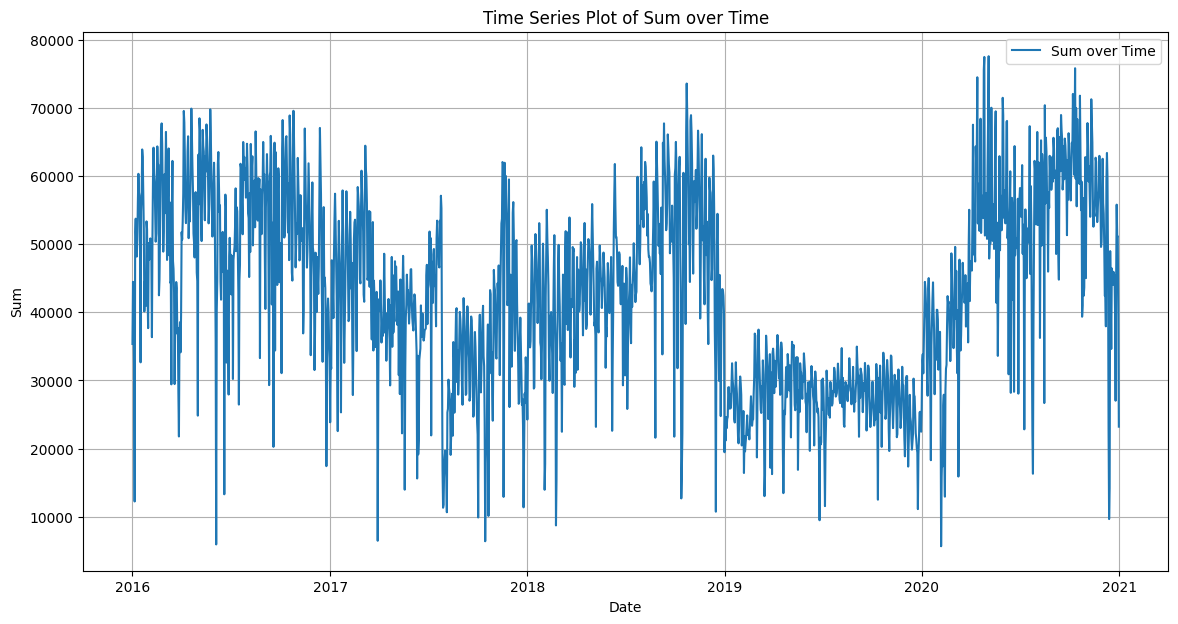

In [6]:
# Create a figure for plotting with a specified size
plt.figure(figsize=(14, 7))

# Plot the 'Sum' column from the 'merged_df' DataFrame against the index (assumed to be time)
plt.plot(merged_df.index, merged_df['Sum'], label='Sum over Time')

# Set the title of the plot
plt.title('Time Series Plot of Sum over Time')

# Set the labels for the x and y axes
plt.xlabel('Date')
plt.ylabel('Sum')

# Display a legend in the plot
plt.legend()

# Display a grid in the plot
plt.grid(True)

# Show the plot
plt.show()

1. Data Range: The chart displays data from 2016 to 2021.

2. Overall Trends:

   a. From 2016 to around mid-2017, the "Sum" values show an upward trend.

   b. From mid-2017 to mid-2018, there is a slight decline, followed by another upward trend from mid-2018 to early 2019.

   c. There is a significant decline from 2019 to early 2020, followed by a recovery starting in mid-2020.

   d. From mid-2020 to 2021, the "Sum" values show another upward trend.

3. Data Volatility: Throughout the entire time series, the "Sum" values exhibit significant volatility. This suggests that there are periods within the considered timeframe where the growth or decline in "Sum" values is quite dramatic.

4. Highs and Lows:

   a. In 2017 and 2021, we can observe some peaks in the "Sum" values, which may represent the high points during those periods.
   
   b. In contrast, the period from 2019 to early 2020 shows a trough in "Sum" values.

Summary: The chart illustrates the trends in "Sum" values over time, with several noticeable cycles of increase and decrease. For further analysis, more background information about the "Sum" column would be necessary to better understand the reasons behind these trends.

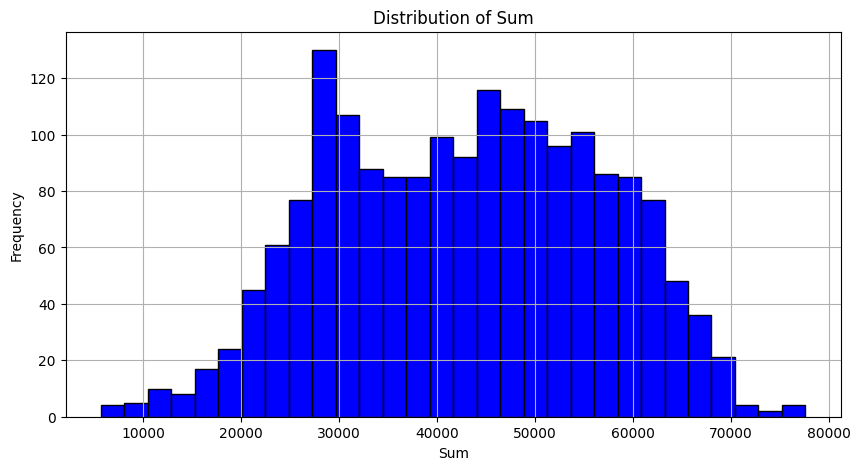

In [7]:
# Create a figure for plotting with a specified size
plt.figure(figsize=(10, 5))

# Create a histogram of the 'Sum' column from the 'merged_df' DataFrame
plt.hist(merged_df['Sum'], bins=30, color='blue', edgecolor='black')

# Set the title of the plot
plt.title('Distribution of Sum')

# Set the label for the x-axis
plt.xlabel('Sum')

# Set the label for the y-axis
plt.ylabel('Frequency')

# Display a grid in the plot
plt.grid(True)

# Show the plot
plt.show()

1. Shape: The data distribution depicted in the chart resembles a distribution close to a normal distribution, but with a slight rightward skew (positive skew). This means that the median of "Sum" values is less than the mean.

2. Central Region: The majority of "Sum" values are concentrated between 30,000 and 60,000. This is the primary central region of the data.

3. High-Frequency Range: The highest frequency range in the chart corresponds to "Sum" values approximately between 27,500 and 30,000. This indicates that values in this range occur most frequently.

4. Extreme Values: The frequencies of lower "Sum" values (less than 20,000) and higher "Sum" values (greater than 70,000) are relatively low. These can be considered as outliers or extreme values in the data.

5. Frequency Distribution: The frequencies of "Sum" values within most intervals are relatively consistent, but there are some intervals (e.g., 10,000 to 20,000 and 60,000 to 70,000) where the frequency drops.

Summary: This chart provides insights into the distribution of "Sum" values. The data primarily clusters within a specific range, but there are also outliers. Understanding the sources and significance of these "Sum" values would be helpful for further analysis.

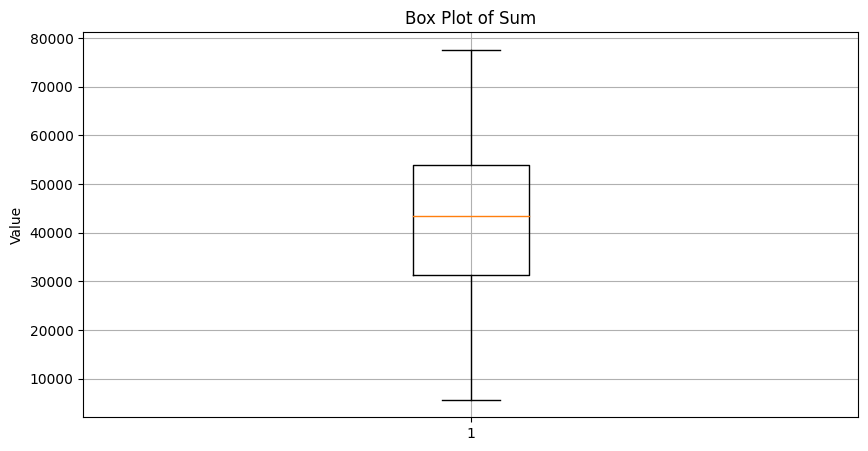

In [8]:
# Create a figure for plotting with a specified size
plt.figure(figsize=(10, 5))

# Create a box plot of the 'Sum' column from the 'merged_df' DataFrame
plt.boxplot(merged_df['Sum'])

# Set the title of the plot
plt.title('Box Plot of Sum')

# Set the label for the y-axis
plt.ylabel('Value')

# Display a grid in the plot
plt.grid(True)

# Show the plot
plt.show()

1. Median: The orange line represents the median of the data, which represents the central position of all "Sum" values. Here, it appears to be around the vicinity of 45,000.

2. Quartiles: The upper and lower edges of the box plot represent the third quartile (Q3) and the first quartile (Q1). This means that approximately 50% of the data values fall within this range. From the plot, we can see that this range is approximately between 35,000 and 55,000.

3. Outliers: The lines (whiskers) outside the box plot represent the maximum and minimum values within the normal range of data values. Any points beyond these lines can be considered as outliers. Here, we can see some lower outliers, which are below 10,000.

4. Overall Distribution: The box plot provides an overall overview of the data distribution. From the position of the median, we can see that the distribution of "Sum" values is relatively balanced, but there are some lower outliers.

Summary: This box plot provides us with a quick view of the distribution of "Sum" values. We can clearly see the central location of the data, the spread of the data, and any potential outliers.

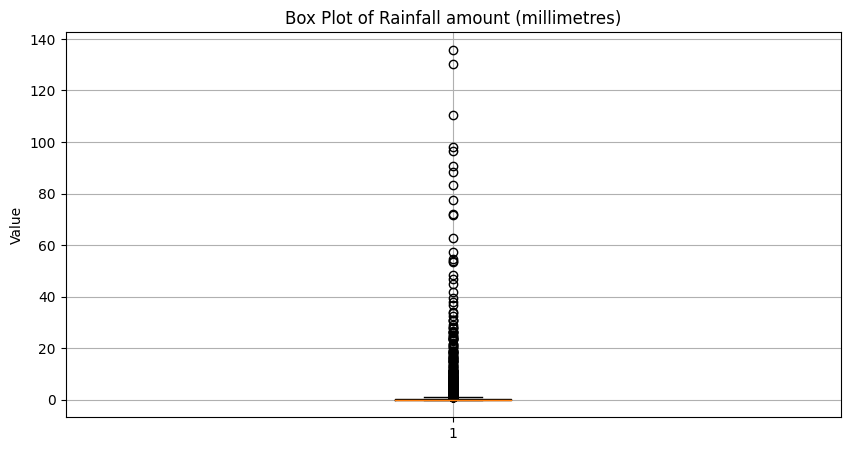

In [9]:
# Create a figure for plotting with a specified size
plt.figure(figsize=(10, 5))

# Create a box plot of the 'Rainfall amount (millimetres)' column from the 'merged_df' DataFrame
plt.boxplot(merged_df['Rainfall amount (millimetres)'])

# Set the title of the plot
plt.title('Box Plot of Rainfall amount (millimetres)')

# Set the label for the y-axis
plt.ylabel('Value')

# Display a grid in the plot
plt.grid(True)

# Show the plot
plt.show()

1. Median: The orange line in the box plot represents the median of the data. From here, we can see that the median rainfall is close to 0, indicating that the majority of observations have low or no rainfall.

2. Quartiles: The upper and lower edges of the box plot represent the third quartile (Q3) and the first quartile (Q1). In this example, these two values are very close to the median, once again confirming that most observations have very low rainfall.

3. Outliers: We can see a significant number of outlier points above the box plot, indicating that on certain days, rainfall far exceeds the normal range. This could be due to seasonal rainfall or specific weather events.

4. Overall Distribution: Most of the rainfall observations are concentrated around 0, but there are also some extremely high outliers. This may suggest that the area experiences dry conditions most of the time, but occasionally sees intense rainfall events.

Summary: From this box plot, we can conclude that most of the time, the area experiences very low rainfall, but there are occasional days with extremely high rainfall. This pattern may be related to specific climate types or seasonal weather patterns.

In [10]:
# Convert the index of 'merged_df' to datetime format
merged_df.index = pd.to_datetime(merged_df.index)

# Calculate the number of days since the epoch (1970-01-01) for each date in the index
days_since_epoch = (merged_df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

# Add a new column 'Days_Since_Epoch' to 'merged_df' with the calculated values
merged_df['Days_Since_Epoch'] = days_since_epoch

# Calculate the correlation matrix for selected columns in 'merged_df' ('Days_Since_Epoch', 'Rainfall amount (millimetres)', 'Sum')
correlation_matrix = merged_df[['Days_Since_Epoch', 'Rainfall amount (millimetres)', 'Sum']].corr()

# Print the correlation matrix
print(correlation_matrix)

                               Days_Since_Epoch  \
Days_Since_Epoch                       1.000000   
Rainfall amount (millimetres)          0.000024   
Sum                                   -0.133839   

                               Rainfall amount (millimetres)       Sum  
Days_Since_Epoch                                    0.000024 -0.133839  
Rainfall amount (millimetres)                       1.000000 -0.185823  
Sum                                                -0.185823  1.000000  


1. Relationship between Days_Since_Epoch and Rainfall amount (millimetres): The correlation is 0.000024, indicating that there is almost no linear relationship between them. This means that there is no apparent trend or correlation between the number of days since the epoch and the amount of rainfall.

2. Relationship between Days_Since_Epoch and Sum: The correlation is -0.133839, suggesting a slight negative correlation between them. This may imply that over time, there is a minor decrease in the "Sum" values, but this correlation is not strong.

3. Relationship between Rainfall amount (millimetres) and Sum: The correlation is -0.185823, indicating a certain degree of negative correlation between the two. When rainfall amount increases, the "Sum" values may slightly decrease, or vice versa.

Summary:

1. There is no apparent association between the number of days since the epoch and rainfall amount.

2. Over time, there might be a minor decrease in "Sum" values, but this trend is not pronounced.

3. There is a slight negative correlation between rainfall amount and "Sum," but more data or further analysis is needed to determine the true nature of the relationship between these two variables.

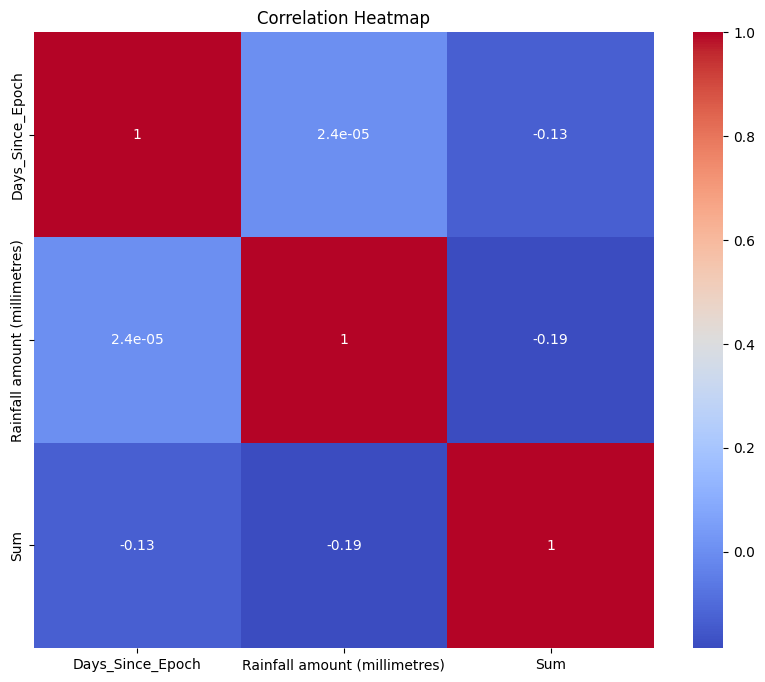

In [11]:
# Set the size of the heatmap figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix with annotations and the 'coolwarm' color map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set the title of the heatmap
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()

1. Color Key: Red indicates positive correlation, blue indicates negative correlation, and the intensity of the color represents the strength of the correlation. The darker the color, the stronger the correlation.

2. Relationship between Days_Since_Epoch and Itself: Autocorrelation is 1 (red cell), as expected, because the correlation of any variable with itself is always 1.

3. Relationship between Days_Since_Epoch and Rainfall amount (millimetres): The correlation is 2.4e-05 (almost a neutral color), indicating that there is almost no linear relationship between them.

4. Relationship between Days_Since_Epoch and Sum: The correlation is -0.13 (pale blue cell), suggesting a slight negative correlation between the two.

5. Relationship between Rainfall amount (millimetres) and Sum: The correlation is -0.19 (pale blue cell), indicating a certain degree of negative correlation between the two.

Summary:

1. Colors closer to neutral in the heatmap represent lower correlations. For example, the correlation between Days_Since_Epoch and Rainfall amount (millimetres) is very low.

2. There is a slight negative correlation between Days_Since_Epoch and Sum, as well as between Rainfall amount (millimetres) and Sum, but the correlations are not strong.

3. The heatmap provides an intuitive way to visualize the correlations between variables in the data.

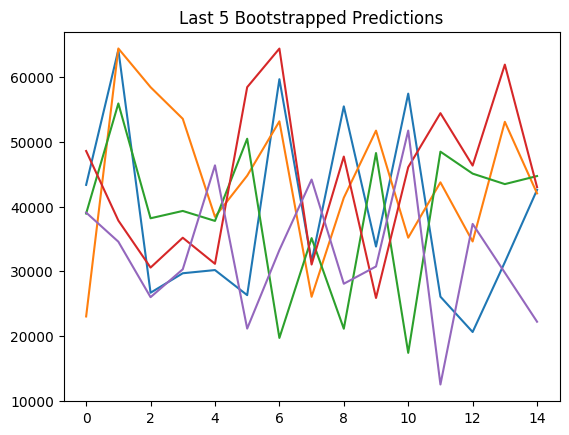

In [12]:
# Set the value of H (forecast horizon) to 15
H = 15

# Set the number of bootstrap samples
n_bootstrap_samples = 1000

# Initialize a list to store bootstrapped predictions
y_pred_bootstrap = []

# Generate bootstrapped samples and predictions
for _ in range(n_bootstrap_samples):
    # Randomly sample with replacement from the 'Sum' column of merged_df
    sample = merged_df['Sum'].sample(frac=1, replace=True)
    
    # Extract the last H values from the bootstrapped sample as a forecast
    forecast = sample.iloc[-H:].values
    y_pred_bootstrap.append(forecast)

# Define a function to transpose a 2D list
def transposed_2d_list(l):
    return [[row[i] for row in l] for i in range(len(l[0]))]

# Plot the last 5 bootstrapped prediction lines
plt.plot(transposed_2d_list(y_pred_bootstrap[-5:]))
plt.title('Last 5 Bootstrapped Predictions')
plt.show()

1. Diversity of Predictions: The five different lines represent the predictions from five different bootstrap samples. Each bootstrap sample is randomly drawn with replacement from the Sum column, explaining why each line has different trends and fluctuations.

2. Range of Predictions: The values of all prediction lines roughly lie between 20,000 and 80,000. Although they do exhibit volatility, they generally fall within this range.

3. Volatility: The graph shows significant fluctuations between the predictions. This volatility may stem from the varying trends and randomness in the original data.

4. Trend Analysis: While each prediction line has its unique trend and shape, there isn't a uniform upward or downward trend apparent across all predictions. This suggests that based on the current data and bootstrap method, it's challenging to pinpoint a definitive future trend.

Summary:

1. Bootstrapping is a statistical method used to assess the uncertainty of a statistic by repeatedly drawing multiple bootstrap samples from the sample data with replacement.

2. Observing these five prediction lines gives us an intuitive understanding of the uncertainty and variability of future forecasts.

3. These predictions offer multiple potential future paths, assisting decision-makers in understanding possible outcomes under different scenarios and providing a reference for planning and strategizing.

In [13]:
# Create a DataFrame to store bootstrap predictions with an index of the last H dates
bootstrap_predictions = pd.DataFrame(index=merged_df.index.values[-H:])

# Generate bootstrap percentiles
for pctl in range(0, 101, 10):
    # Calculate percentiles along the columns (axis=0) of y_pred_bootstrap
    bootstrap_predictions[str(pctl)] = np.percentile(y_pred_bootstrap, pctl, axis=0)

# Rename the '50' column to 'median'
bootstrap_predictions.rename(columns={'50': "median"}, inplace=True)

# Add a column 'actuals' containing the actual values for the last H dates
bootstrap_predictions['actuals'] = merged_df['Sum'].values[-H:]

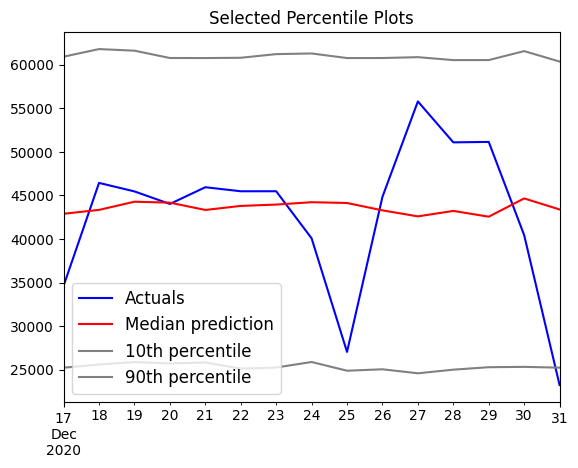

In [14]:
# Create a figure and axis object for the plot
fig, ax_bootstrap_2 = plt.subplots()

# Plot the actual values in blue
bootstrap_predictions['actuals'].plot(color='blue', label='Actuals', ax=ax_bootstrap_2)

# Plot the median prediction in red
bootstrap_predictions['median'].plot(color='red', label='Median prediction', ax=ax_bootstrap_2)

# Plot the 10th and 90th percentiles in grey as shaded regions
bootstrap_predictions['10'].plot(color='grey', label='10th percentile', ax=ax_bootstrap_2)
bootstrap_predictions['90'].plot(color='grey', label='90th percentile', ax=ax_bootstrap_2)

# Add a legend to the lower left corner of the plot
plt.legend(loc='lower left', fontsize=12)

# Set the title of the plot
plt.title('Selected Percentile Plots')

# Display the plot
plt.show()

1. Actual Values vs. Median Predictions:

    a. The blue line represents actual values, while the red line represents median predictions. Most of the time, they are very close, indicating that the median predictions provide a reasonably good approximation of the actual values.

    b. However, there are some differences, especially from December 26th to 30th, where the actual values surpass the median predictions.

2. Confidence Intervals:

    a. The gray lines represent the 10th and 90th percentiles, providing a confidence interval for the predictions.

    b. On most days, actual values fall within this confidence interval, indicating that 80% of the bootstrap samples' predictions are within this range.

    c. However, the actual values are well above the 90th percentile, suggesting that on these days, the actual values exceed the predictions of 90% of the bootstrap samples.

3. Volatility:

    a. There is noticeable volatility from December 26th to 30th, where actual values rapidly rise and then drop.

    b. The median predictions do not capture these extreme peaks, suggesting that the bootstrap method may not fully capture extreme events or outliers in the data.

Summary:

1. While bootstrap predictions provide valuable insights into potential outcomes and their likelihood, they may not always effectively capture extreme or unexpected events.

2. The confidence interval from the 10th to the 90th percentile provides a useful range where actual values are expected to fall. However, outliers or extreme values may sometimes fall outside of these bounds.

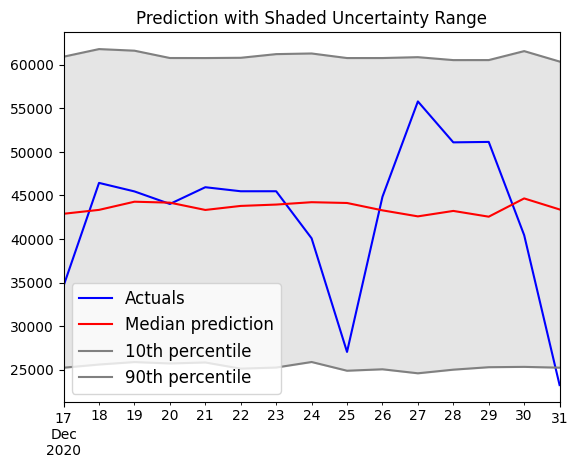

In [15]:
# Create a figure and axis object for the plot
fig, ax_bootstrap = plt.subplots()

# Plot the actual values in blue
bootstrap_predictions['actuals'].plot(color='blue', label='Actuals', ax=ax_bootstrap)

# Plot the median prediction in red
bootstrap_predictions['median'].plot(color='red', label='Median prediction', ax=ax_bootstrap)

# Plot the 10th and 90th percentiles in grey as shaded regions
bootstrap_predictions['10'].plot(color='grey', label='10th percentile', ax=ax_bootstrap)
bootstrap_predictions['90'].plot(color='grey', label='90th percentile', ax=ax_bootstrap)

# Add a legend to the lower left corner of the plot
plt.legend(loc='lower left', fontsize=12)

# Define x values for filling between
x = merged_df.index.values[-H:]

# Fill the area between the 10th and 90th percentiles with grey shading
plt.fill_between(x, bootstrap_predictions['10'], bootstrap_predictions['90'], color='grey', alpha=0.2)

# Set the title of the plot
plt.title('Prediction with Shaded Uncertainty Range')

# Display the plot
plt.show()

1. Actual Values vs. Median Predictions:

The blue line represents actual values, while the red line represents median predictions. On most dates, they are very close, indicating that the predictions are in close agreement with the actual data. However, from December 26th to 30th, the actual values exceed the median predictions, indicating significant fluctuations in the actual data during these days.

2. Uncertainty Range:

The gray lines represent the 10th and 90th percentile predictions, and the area between them is shaded in light gray, representing the uncertainty range of the predictions. Actual values fall within this range on most dates, suggesting that this range captures approximately 80% of the possible predicted values. However, on December 27th to 29th, the actual values deviate significantly from this range, indicating larger deviations in the actual data during these days.

3. Shaded Confidence Interval:

The light gray shading representing the confidence interval helps us understand the uncertainty and risk associated with the predictions. When actual values fall outside of this range, it indicates a significant deviation from the predictions.

Summary: The plot illustrates the relationship between the median, 10th percentile, and 90th percentile predictions and the actual values. Most of the time, actual data closely aligns with the predictions. However, on certain dates, such as December 27th to 29th, there are significant deviations.

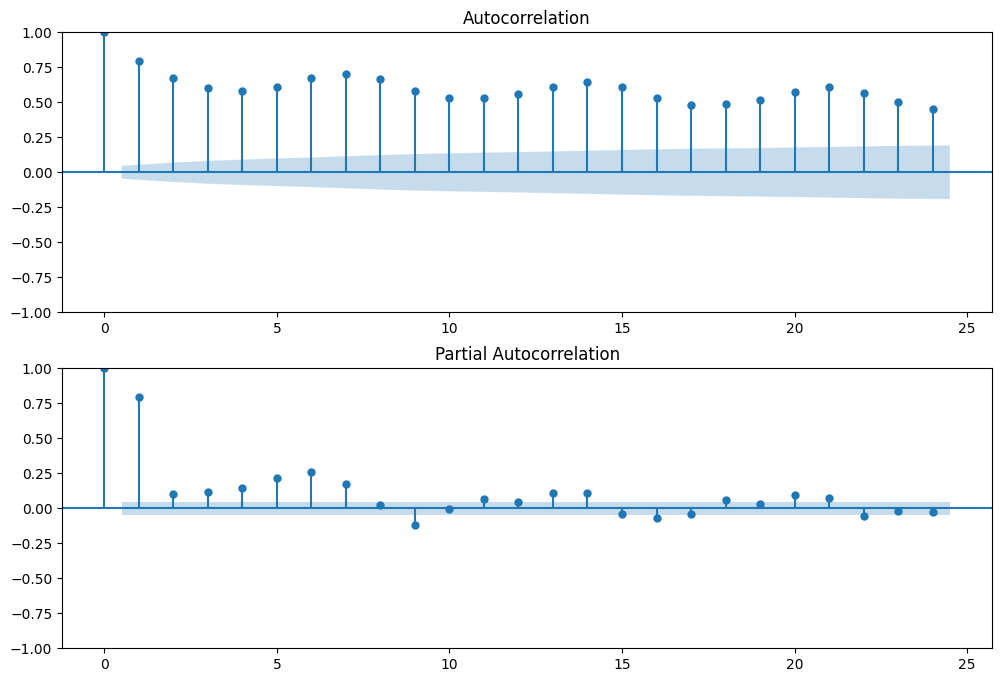

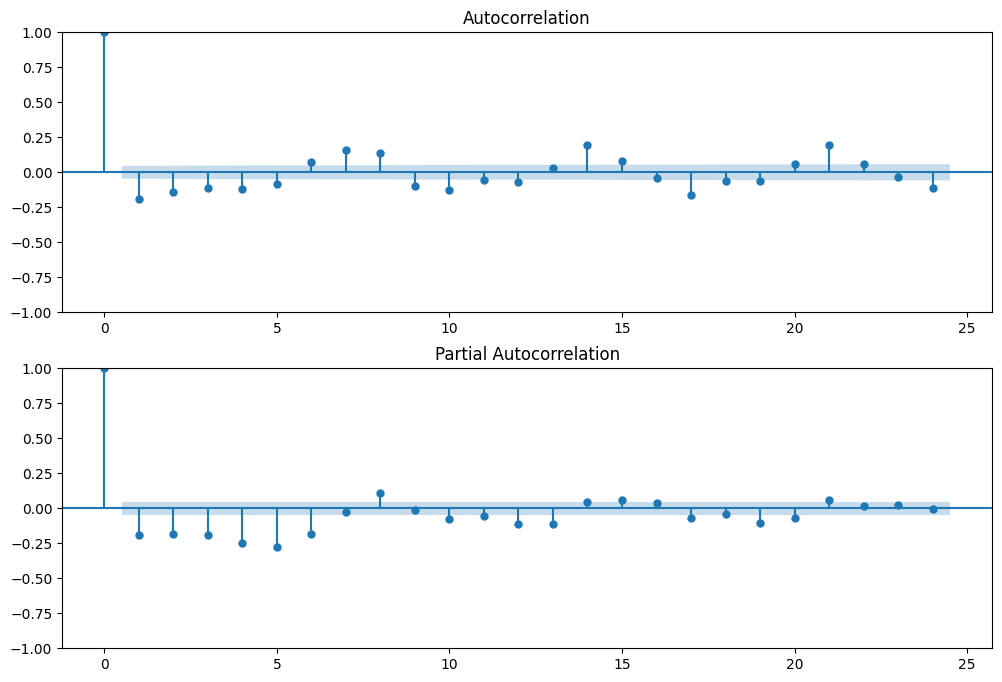

In [16]:
# Original Time Series Data Autocorrelation and Partial Autocorrelation
series_data = merged_df['Sum']

# Create a new figure with two subplots (autocorrelation and partial autocorrelation)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)

# Plot the autocorrelation function (ACF)
fig = sm.graphics.tsa.plot_acf(series_data, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)

# Plot the partial autocorrelation function (PACF)
fig = sm.graphics.tsa.plot_pacf(series_data, lags=24, ax=ax2)

# Show the plot
plt.show()

# Differenced Time Series Data Autocorrelation and Partial Autocorrelation
series_data_diff = series_data.diff().dropna()  # Calculate the differenced time series

# Create a new figure with two subplots (autocorrelation and partial autocorrelation)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)

# Plot the autocorrelation function (ACF) for the differenced series
fig = sm.graphics.tsa.plot_acf(series_data_diff, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)

# Plot the partial autocorrelation function (PACF) for the differenced series
fig = sm.graphics.tsa.plot_pacf(series_data_diff, lags=24, ax=ax2)

# Show the plot
plt.show()

1. Autocorrelation Plot:

    a. The autocorrelation plot shows the correlation between the data and itself at different lags.

    b. In the plot, we can see that the autocorrelation at lag 0 is 1, which is expected because any sequence has a perfect correlation with itself.

    c. For other lags, such as 1, 2, 3, etc., the autocorrelation values gradually decrease but remain above the blue shaded confidence interval. This indicates that these lagged values have significant correlations with the original sequence.

2. Partial Autocorrelation Plot:

    a. The partial autocorrelation measures the correlation between a specific lag and the sequence, controlling for the influence of all smaller lags.

    b. In the plot, we observe that the partial autocorrelation is very high at lag 1 and then rapidly decreases.

    c. Starting from lag 3, the partial autocorrelation values become very small and approach zero, implying that after considering the influence of lag 1, higher lags have little correlation with the original sequence.

Summary:

1. These plots provide information about the internal structure of time series data, especially regarding seasonality and trends.

2. The autocorrelation plot indicates strong seasonality in the data, as evidenced by significant autocorrelation at lag values that persist beyond the initial decrease.

3. The partial autocorrelation plot suggests a potential AR(1) model, as after lag 1, the partial autocorrelation rapidly drops to zero.

1. First Plot (Original Time Series Data):

    a. ACF Plot: There's a gradual decrease in the autocorrelation values. The autocorrelations are significant for multiple lags.

    b. PACF Plot: The partial autocorrelation is significant for the first lag and becomes insignificant after that.

2. Second Plot (Differenced Time Series Data):

    a. ACF Plot: The first lag has a significant autocorrelation value, but subsequent lags mostly have values within the confidence interval.

    b. PACF Plot: The first lag has a significant partial autocorrelation value, and the rest of the lags are mostly within the confidence interval.

Summary:

1. The first plot suggests that the original time series has a strong autocorrelation structure. The PACF being significant at the first lag hints at an AR(1) model.

2. The second plot, which is for the differenced series, suggests that the series is now stationary after differencing once. Given the significant ACF and PACF at the first lag, it may be modeled with an ARIMA(1,1,1) model.

# 3. Focus now on the cyclist traffic on the Bicentennial Bikeway, Milton time series.

a. Split the data into training and testing series, selecting the testing series to be the 
last three months of the data.

In [17]:
# Splitting Data into Test and Train Sets

# Selecting the last 3 months of data as the test set
test = merged_df.loc[merged_df.index > merged_df.index.max() - pd.DateOffset(months=3)]

# Creating the training set by excluding the test set data
train = merged_df.drop(test.index)

b. Manually step through the STR decomposition process on the training data, as 
described in the course material. Visualise and interpret each of the components of 
the STR decomposition for cycle traffic. (Validate the output of 
the manual process against an automated modelling approach.)

In [18]:
# Handling Missing Data and Seasonal Decomposition

# Filling missing values in the 'Sum' column using forward fill (last known value)
filled_data = merged_df['Sum'].fillna(method='ffill')

# Performing seasonal decomposition on the filled data using an additive model with a period of 365 days
decomposition = seasonal_decompose(filled_data, model='additive', period=365)

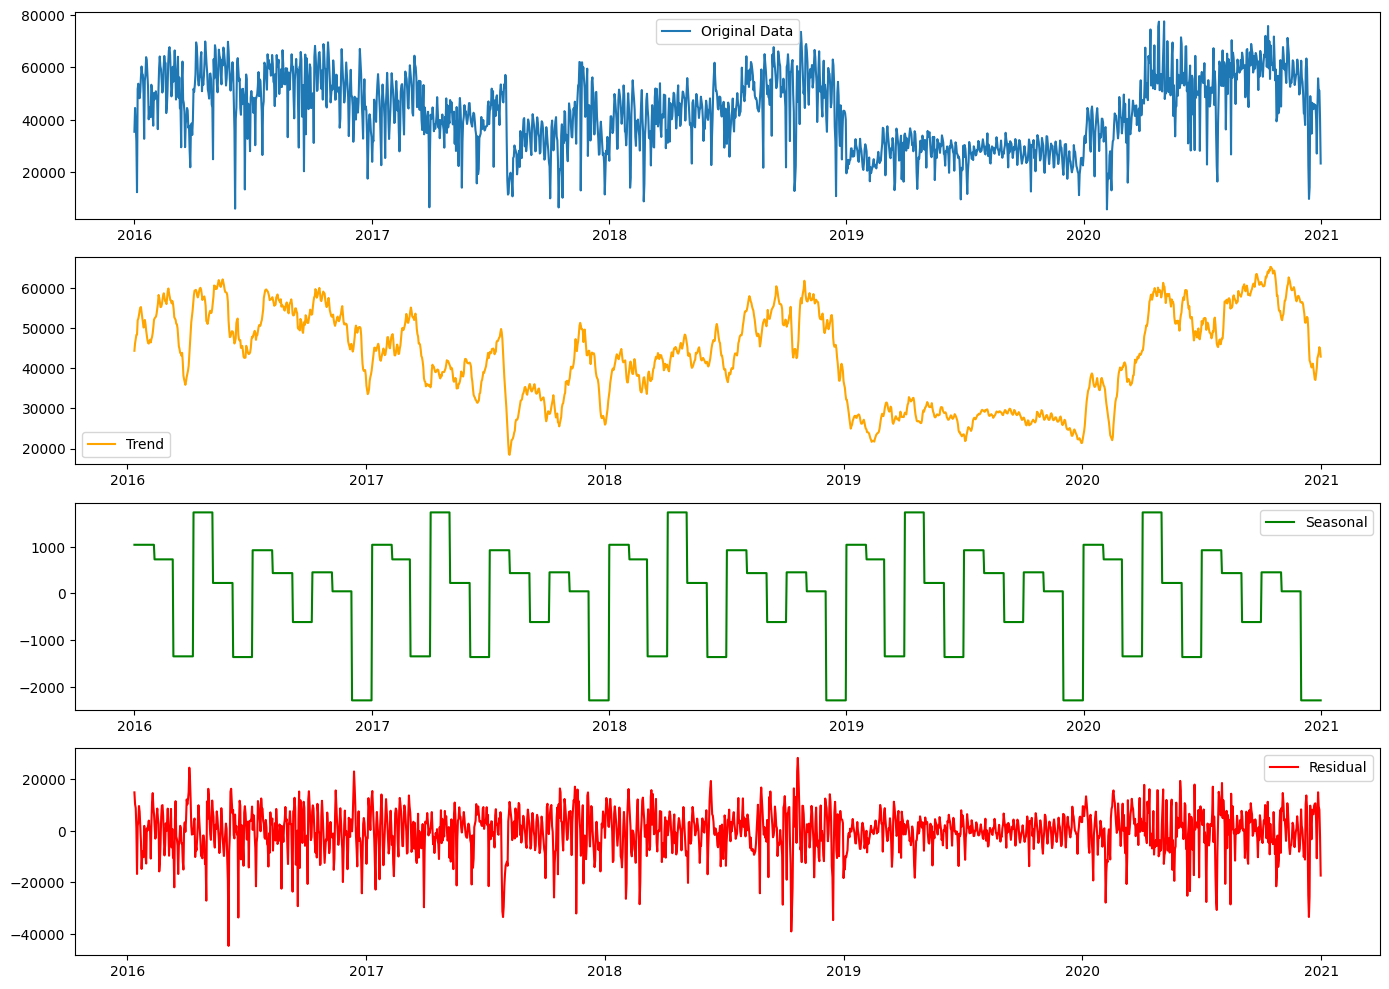

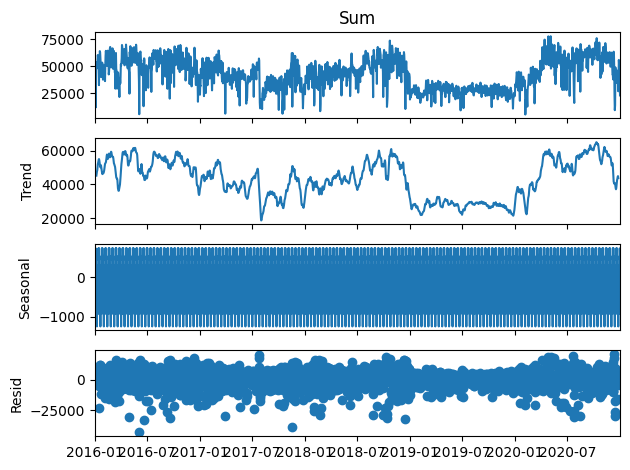

In [19]:
# Time Series Decomposition and Visualization

# Checking if 'Date' column exists in the DataFrame
if 'Date' in merged_df.columns:
    # Converting the 'Date' column to datetime format
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    # Setting 'Date' as the index of the DataFrame
    merged_df.set_index('Date', inplace=True)

# Calculating the rolling mean (trend) with a window size of 12 months
merged_df['Trend'] = merged_df['Sum'].rolling(window=12).mean()

# Calculating the detrended component by subtracting the trend from the original data
merged_df['Detrended'] = merged_df['Sum'] - merged_df['Trend']

# Estimating monthly seasonality by calculating the mean of detrended data for each month
monthly_seasonality = merged_df['Detrended'].groupby(merged_df.index.month).mean()
merged_df['Seasonal'] = merged_df.index.map(lambda d: monthly_seasonality[d.month])

# Calculating the residual component by subtracting the trend and seasonality from the original data
merged_df['Residual'] = merged_df['Sum'] - merged_df['Trend'] - merged_df['Seasonal']

# Creating subplots to visualize the original data, trend, seasonal, and residual components
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(merged_df['Sum'], label='Original Data')
plt.legend(loc='best')

plt.subplot(4, 1, 2)
plt.plot(merged_df['Trend'], label='Trend', color='orange')
plt.legend(loc='best')

plt.subplot(4, 1, 3)
plt.plot(merged_df['Seasonal'], label='Seasonal', color='green')
plt.legend(loc='best')

plt.subplot(4, 1, 4)
plt.plot(merged_df['Residual'], label='Residual', color='red')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Performing seasonal decomposition using the 'additive' model with a seasonality period of 12 months
decomposition = seasonal_decompose(merged_df['Sum'], model='additive', period=12)

# Plotting the decomposed components (trend, seasonal, and residuals)
decomposition.plot()
plt.show()

1. Original Data:

   a. This represents the raw time series data without any manipulation.

   b. Observations show fluctuations throughout the years, with some visible seasonal patterns.

2. Trend:

   a. This captures the underlying trend in the data when any seasonality and noise are removed.

   b. It appears to be a smooth curve that provides a general upward or downward movement over time.

   c. From the chart, we can see a general decline from 2016 to the end of 2019, after which it begins to rise until 2021.

3. Seasonal:

   a. This component captures the repeating short-term cycle in the series.

   b. The chart suggests a clear annual seasonal pattern, with specific times in the year experiencing highs and specific times seeing lows.

4. Residual:

   a. These are the random variations in the series after the trend and seasonal components are removed.

   b. It represents the noise or error in the series.
   
   c. The residuals fluctuate around zero, indicating that the trend and seasonal components have been effectively captured, leaving behind only the noise.

From the decomposition, it's evident that there's a strong seasonality in the data and an underlying trend.

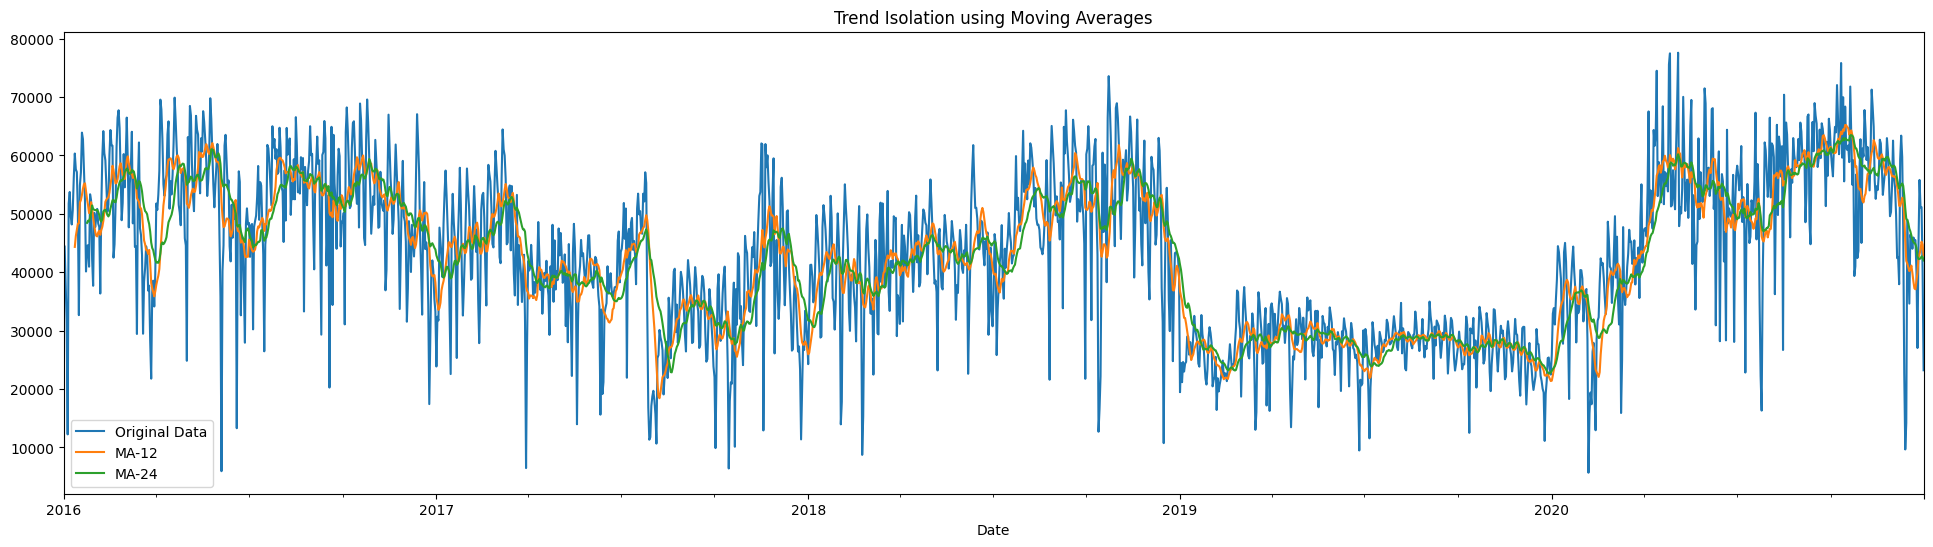

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

In [20]:
# Creating Moving Averages and Further Decomposition

# Calculating the 12-month moving average and 24-month moving average of the 'Sum' column
merged_df['MA-12'] = merged_df['Sum'].rolling(window=12).mean()
merged_df['MA-24'] = merged_df['Sum'].rolling(window=24).mean()

# Creating a large figure for visualization
plt.figure(figsize=(24, 6))

# Plotting the original data, 12-month moving average, and 24-month moving average
merged_df[['Sum', 'MA-12', 'MA-24']].plot(ax=plt.gca())

# Adding legends and title to the plot
plt.legend(['Original Data', 'MA-12', 'MA-24'])
plt.title("Trend Isolation using Moving Averages")
plt.show()

# Calculating the detrended component by subtracting the 12-month moving average from the original data
merged_df['Detrended'] = merged_df['Sum'] - merged_df['MA-12']

# Estimating monthly seasonality by calculating the mean of the detrended data for each month
monthly_seasonality = merged_df['Detrended'].groupby(merged_df.index.month).mean()
merged_df['Seasonal'] = merged_df.index.map(lambda d: monthly_seasonality[d.month])

# Calculating the residual component by subtracting the 12-month moving average and seasonal components from the original data

# Creating a new figure for visualization
plt.figure(figsize=(14, 10))

1. Original Data:

    a. The blue line represents the original data, which exhibits a lot of fluctuations and seasonality.

    b. We can observe the relationship between the data's fluctuations and changes over time.

2. 12-Month Moving Average (MA-12):

    a. The orange line represents the 12-month moving average, providing a smoother view that helps reveal mid-term trends hidden behind the noise.

    b. Through this line, we can identify certain trends in the data, especially the peaks and valleys.

3. 24-Month Moving Average (MA-24):

    a. The green line represents the 24-month moving average. Due to the larger window size, it is even smoother than the 12-month moving average, highlighting long-term trends.

    b. This line further removes seasonality and short-term fluctuations in the data, emphasizing the long-term trend.

Summary:

1. Using moving averages effectively isolates trends in time series data.

2. Both the orange MA-12 and the green MA-24 provide different perspectives on data trends. The 12-month moving average closely follows the original data, while the 24-month moving average offers a longer-term trend view.

3. From 2018 to 2019, there was a noticeable downward trend in the data. Subsequently, in early 2020, the trend began to rise.

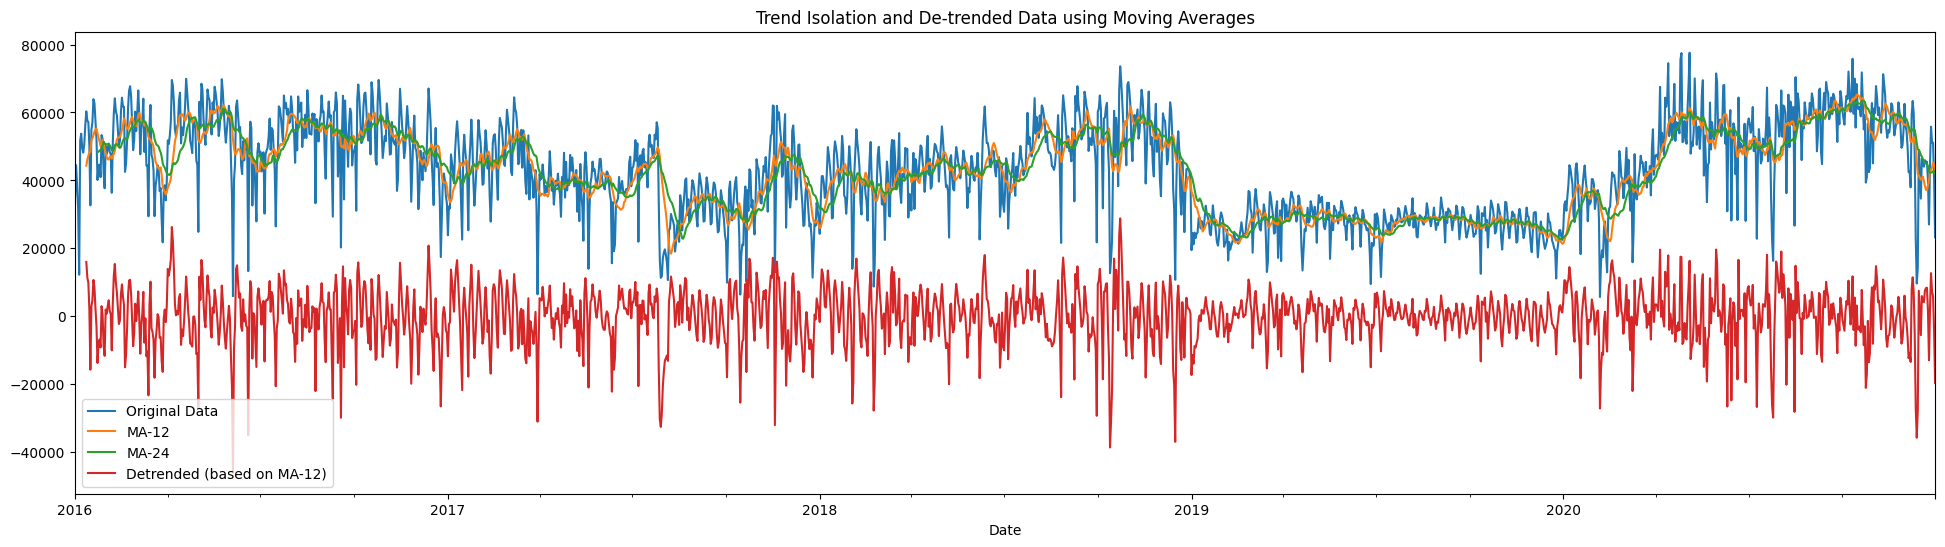

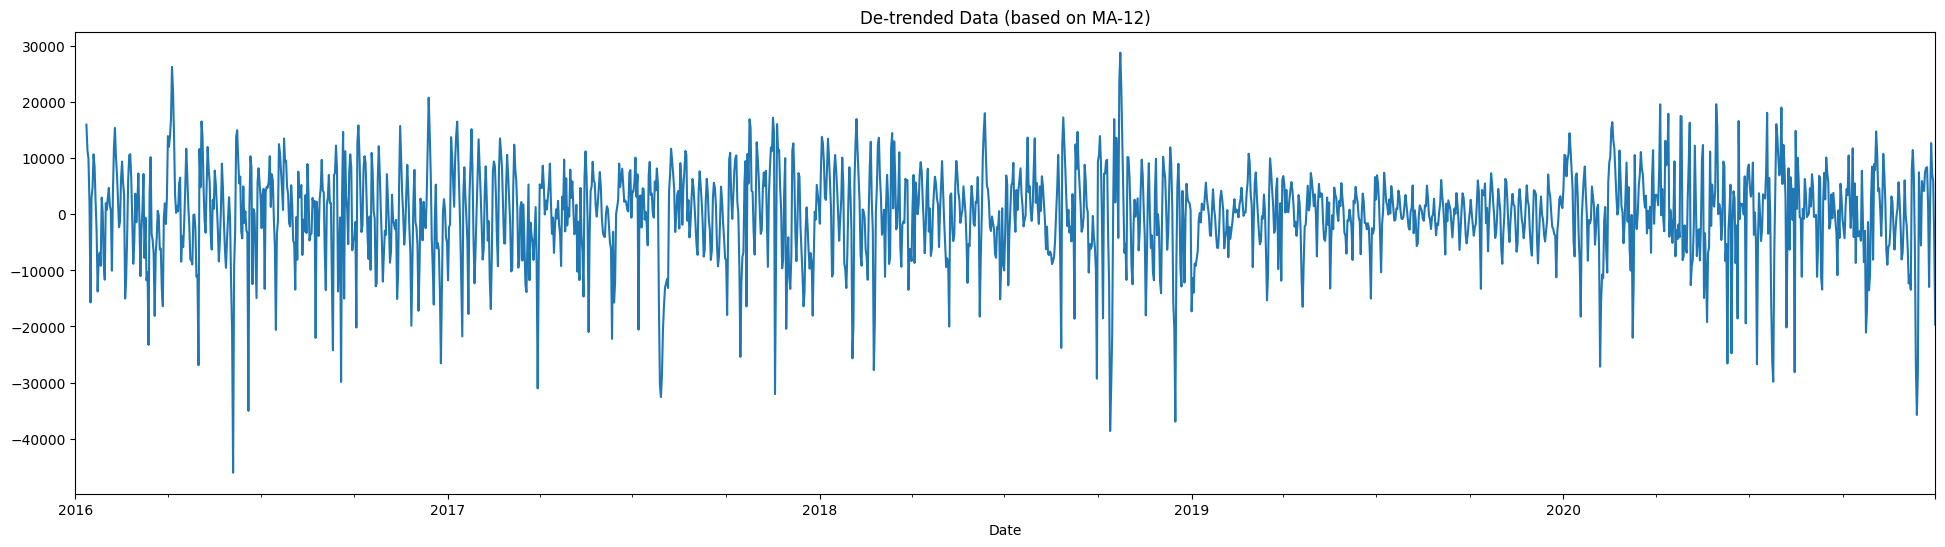

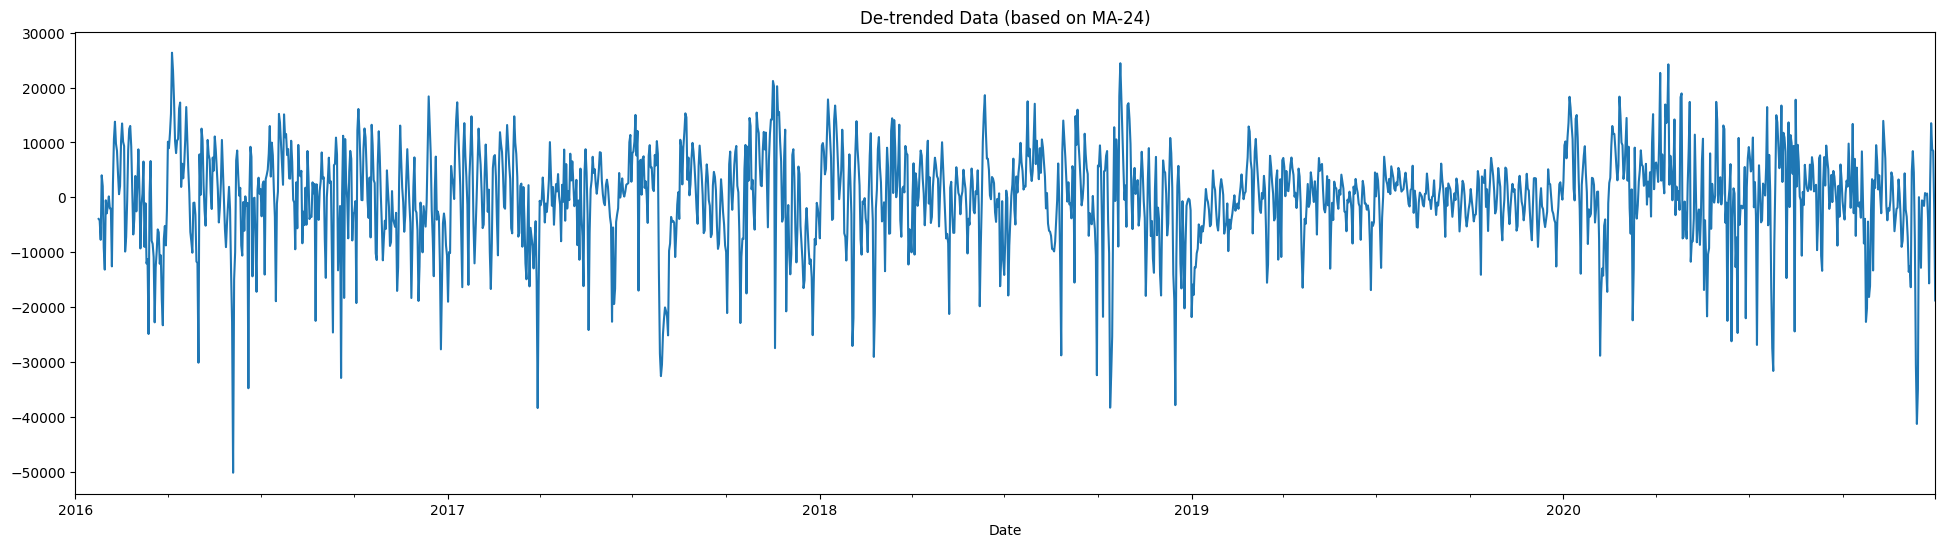

In [21]:
# Visualizing Trend Isolation and De-trended Data using Moving Averages

# Creating a large figure for visualization
plt.figure(figsize=(24, 6))

# Plotting the original data, 12-month moving average, 24-month moving average, and the detrended data based on MA-12
merged_df[['Sum', 'MA-12', 'MA-24', 'Detrended']].plot(ax=plt.gca())

# Adding legends and a title to the plot
plt.legend(['Original Data', 'MA-12', 'MA-24', 'Detrended (based on MA-12)'])
plt.title("Trend Isolation and De-trended Data using Moving Averages")
plt.show()

# Creating a new figure for visualization
plt.figure(figsize=(24, 6))

# Plotting the detrended data based on MA-12
merged_df['Detrended'].plot(ax=plt.gca())

# Adding a title to the plot
plt.title("De-trended Data (based on MA-12)")
plt.show()

# Creating a new column 'Detrended-24' by subtracting the 24-month moving average from the original data
merged_df['Detrended-24'] = merged_df['Sum'] - merged_df['MA-24']

# Creating a new figure for visualization
plt.figure(figsize=(24, 6))

# Plotting the detrended data based on MA-24
merged_df['Detrended-24'].plot(ax=plt.gca())

# Adding a title to the plot
plt.title("De-trended Data (based on MA-24)")
plt.show()

1. Original Data: The blue curve represents the original data, showing fluctuations within a certain range and exhibiting some periodicity.

2. 12-Month Moving Average (MA-12): The orange curve is smoother and represents the 12-month average. Through this line, we can observe the long-term trend in the data, reducing short-term volatility.

3. 24-Month Moving Average (MA-24): The green curve is even smoother and represents the 24-month average. This line provides a longer-term trend perspective, further smoothing out short-term fluctuations.

4. Detrended Data Based on MA-12:
The red curve represents data obtained by subtracting the 12-month moving average from the original data. This demonstrates the pure fluctuations in the data without considering long-term trends.

Summary:

1. From 2016 to 2020, the original data exhibited clear cyclical patterns of ups and downs. This could be due to seasonality, economic cycles, or other factors.

2. Both MA-12 and MA-24 successfully captured the primary trends in the original data, with MA-24 being smoother.

3. Detrended data can help us better understand short-term fluctuations and outliers in the data without being influenced by long-term trends.

1. Original Data: From the chart, it is evident that the original data exhibits significant fluctuations, which may be attributed to various factors, including seasonality, random events, or other external influences.

2. 12-Month Moving Average (MA-12): MA-12 helps smooth out short-term fluctuations, providing a clearer view of medium-term trends. The data curve appears relatively stable after applying the 12-month moving average.

3. 24-Month Moving Average (MA-24): MA-24 further diminishes the impact of seasonality, making the data's trend more pronounced. Compared to MA-12, the MA-24 curve is even smoother.

4. Detrended Data Based on MA-12: This data is obtained by subtracting the 12-month moving average from the original data. It illustrates the fluctuations remaining after removing the medium-term trend, useful for studying the data's seasonality and random factors.

5. Detrended Data Based on MA-24: Similar to the data based on MA-12, this is derived by subtracting the 24-month moving average from the original data. This data emphasizes the seasonality and random fluctuations in the original data.

Summary: Overall, using the moving average method aids in better understanding the long-term trends, seasonality, and random factors within the data. From the chart, it can be observed that both 12-month and 24-month moving averages result in detrended data with significant fluctuations, suggesting the presence of strong seasonality or other cyclical factors in the data.

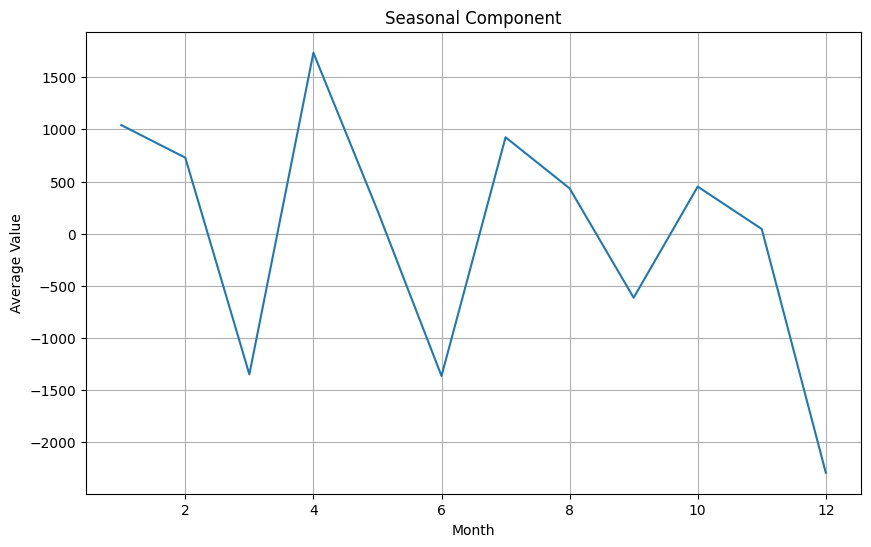

In [22]:
# Calculating the 12-month moving average of the 'Sum' column
merged_df['MA-12'] = merged_df['Sum'].rolling(window=12).mean()

# Calculating the detrended component by subtracting the 12-month moving average from the original data
merged_df['Detrended'] = merged_df['Sum'] - merged_df['MA-12']

# Grouping the data by month and calculating the mean of the detrended values for each month
monthly_means = merged_df.groupby(merged_df.index.month)['Detrended'].mean()

# Creating a figure for visualization
plt.figure(figsize=(10, 6))

# Plotting the average monthly values of the detrended component
monthly_means.plot()

# Adding a title and labels to the plot
plt.title("Seasonal Component")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()

1. Seasonal Peaks: In April and July, the seasonal component reaches two distinct peaks, averaging around 1000. This implies that in these two months, the original data values tend to be higher than their 12-month moving average.

2. Seasonal Troughs: The chart displays four noticeable troughs in the seasonal component in March, June, September, and December, with December's value approaching -2000. This suggests that in these four months, the original data values often fall below their 12-month moving average.

3. Intermediate Months: In February, May, August, and November, the seasonal component oscillates within the range of approximately -500 to +500, indicating that in these months, the original data values are relatively close to their 12-month moving average.

4. Year-End Decline Trend: Starting from October, the seasonal component shows a clear declining trend, continuing until December. This may imply that towards the end of the year, the original data values decrease progressively.

Summary: This chart reveals the seasonal variations in the data throughout the year, with some months exhibiting data values above the average level, while others fall below. These seasonal changes may be attributed to recurring external factors such as holidays, seasons, or other industry-specific events.

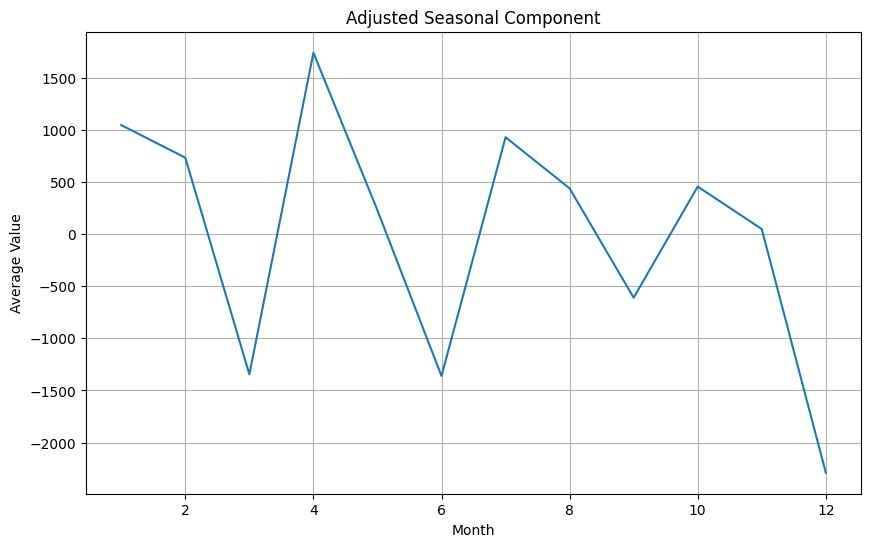

In [23]:
# Calculating the 12-month moving average of the 'Sum' column
merged_df['MA-12'] = merged_df['Sum'].rolling(window=12).mean()

# Calculating the detrended component by subtracting the 12-month moving average from the original data
merged_df['Detrended'] = merged_df['Sum'] - merged_df['MA-12']

# Grouping the data by month and calculating the mean of the detrended values for each month
monthly_means = merged_df.groupby(merged_df.index.month)['Detrended'].mean()

# Calculating the adjustment value as the sum of monthly means divided by 12
adjustment = monthly_means.sum() / 12.0

# Adjusting the monthly means by subtracting the adjustment value
adjusted_monthly_means = monthly_means - adjustment

# Creating a figure for visualization
plt.figure(figsize=(10, 6))

# Plotting the adjusted average monthly values of the detrended component
adjusted_monthly_means.plot()

# Adding a title and labels to the plot
plt.title("Adjusted Seasonal Component")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()

1. Peaks and Troughs: Similar to the previous seasonal component chart, April and July continue to be peak months, while January, May, and December are trough months.

2. Fine-Tuning Effect: In comparison to the original seasonal component, this adjusted chart appears to have undergone some form of fine-tuning or normalization. However, the overall seasonal pattern remains largely unchanged, indicating that the adjusted data more accurately captures the true seasonal effects.

3. Year-End Decline Trend: Starting from October, the adjusted seasonal component still exhibits a pronounced declining trend, suggesting that the data values towards the end of the year remain relatively low even after adjustments.

4. Data Stability: The adjusted data oscillates around the zero line for most months, indicating that the adjusted data is more stable.

Summary: Overall, the adjusted seasonal component chart further emphasizes the seasonal patterns in the data. This adjustment helps to more accurately capture and interpret the seasonal variations in the data.

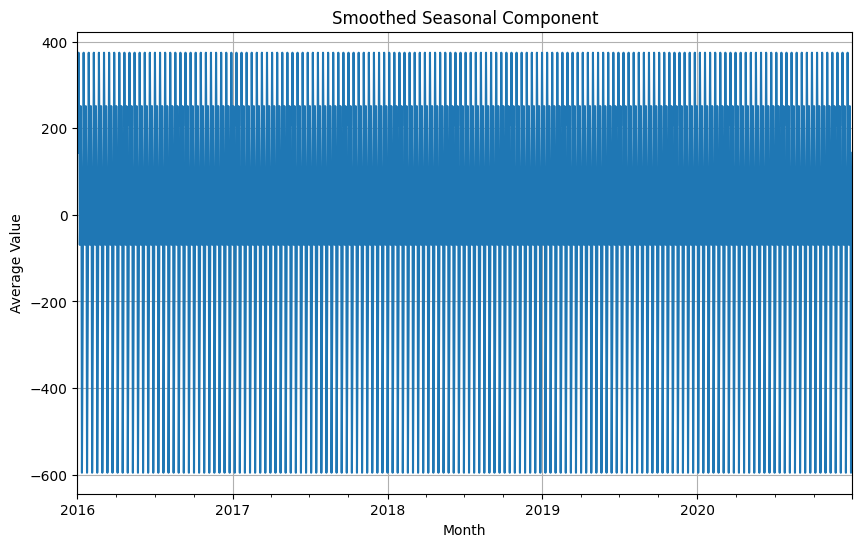

In [24]:
# Calculating the 12-month moving average of the 'Sum' column
merged_df['MA-12'] = merged_df['Sum'].rolling(window=12).mean()

# Calculating the detrended component by subtracting the 12-month moving average from the original data
merged_df['Detrended'] = merged_df['Sum'] - merged_df['MA-12']

# Grouping the data by month and calculating the mean of the detrended values for each month
monthly_means = merged_df.groupby(merged_df.index.month)['Detrended'].mean()

# Calculating the adjustment value as the sum of monthly means divided by 12
adjustment = monthly_means.sum() / 12.0

# Adjusting the monthly means by subtracting the adjustment value
adjusted_monthly_means = monthly_means - adjustment

# Calculating the number of years in the dataset based on 12 months per year
num_years = int(np.floor(len(merged_df) / 12))

# Creating a seasonal component by repeating the adjusted monthly means for the number of years
seasonal = np.tile(adjusted_monthly_means, num_years)

# Checking if the length of the seasonal component is less than the length of the dataset
if len(seasonal) < len(merged_df):
    additional_months = len(merged_df) - len(seasonal)
    seasonal = np.concatenate([seasonal, adjusted_monthly_means[:additional_months]])

# Adding the seasonal component to the DataFrame as 'Seasonal_Adjusted'
merged_df['Seasonal_Adjusted'] = seasonal

# Calculating a smoothed version of the seasonal component using a 3-month rolling mean
merged_df['Seasonal_Smoothed'] = merged_df['Seasonal_Adjusted'].rolling(window=3).mean()

# Creating a figure for visualization
plt.figure(figsize=(10, 6))

# Plotting the smoothed seasonal component
merged_df['Seasonal_Smoothed'].plot()

# Adding a title and labels to the plot
plt.title("Smoothed Seasonal Component")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()

1. Clear Seasonality: From the chart, it's evident that the data exhibits a pronounced seasonality.

2. Regular Patterns: Within each year, you can observe nearly identical patterns of ups and downs. This suggests that over these five years, seasonal factors have had a similar impact on the data during the same periods each year.

3. Smoothing Effect: Compared to previous charts, this one appears smoother. This is because the data has undergone a three-month moving average process, reducing short-term noise in the seasonal component.

4. Upper and Lower Bounds: The smoothed seasonal component fluctuates between approximately +400 and -600, providing a reference range for the magnitude of the seasonal effect.

5. Stability: Despite the cyclical variations occurring each year, these changes appear relatively stable over the five-year time frame. This indicates that the seasonal effects in this dataset haven't undergone significant changes over the past five years.

Summary: Overall, this chart provides an in-depth understanding of the seasonal variations in the data. After smoothing, we can more clearly see the seasonal patterns that occur each year.

/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/1822968709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2016['MA-12'] = merged_df_2016['Sum'].rolling(window=12).mean()
/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/1822968709.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2016['Detrended'] = merged_df_2016['Sum'] - merged_df_2016['MA-12']
/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/1822968709.py:27: SettingWithCopyWarnin

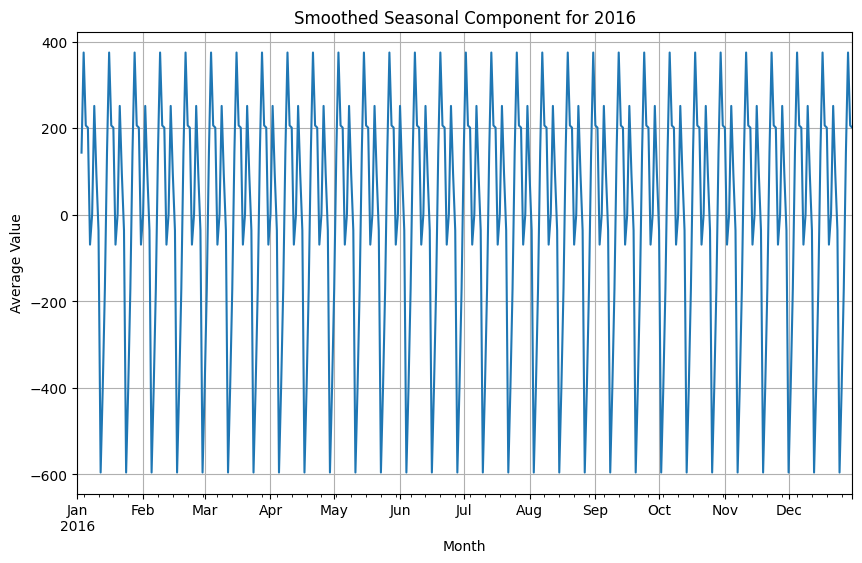

In [25]:
# Filter the DataFrame to include only data from the year 2016
merged_df_2016 = merged_df['2016-01-01':'2016-12-31']

# 1. Calculate the trend component
merged_df_2016['MA-12'] = merged_df_2016['Sum'].rolling(window=12).mean()

# 2. Calculate the de-trended data
merged_df_2016['Detrended'] = merged_df_2016['Sum'] - merged_df_2016['MA-12']

# 3. Estimate the seasonal component
monthly_means = merged_df_2016.groupby(merged_df_2016.index.month)['Detrended'].mean()

# Shift values so that seasonal components sum to zero over the year
adjustment = monthly_means.sum() / 12.0
adjusted_monthly_means = monthly_means - adjustment

# Fill the values of the seasonal component across the entire time series
num_years = int(np.floor(len(merged_df_2016)/12))
seasonal = np.tile(adjusted_monthly_means, num_years)

# Check length: If the length of the time series is not a multiple of 12, we need to adjust
if len(seasonal) < len(merged_df_2016):
    additional_months = len(merged_df_2016) - len(seasonal)
    seasonal = np.concatenate([seasonal, adjusted_monthly_means[:additional_months]])

# Calculate moving average to smooth the data
merged_df_2016['Seasonal_Smoothed'] = merged_df_2016['Seasonal_Adjusted'].rolling(window=3).mean()

# Plot the smoothed seasonal component
plt.figure(figsize=(10, 6))
merged_df_2016['Seasonal_Smoothed'].plot()
plt.title("Smoothed Seasonal Component for 2016")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()

1. Recurring Patterns: The data exhibits a clear and consistent cyclical pattern. This recurring wave-like behavior suggests that there is a strong seasonal influence on the data.

2. Monthly Oscillations: The data oscillates every month, moving from a trough to a peak, then back to a trough. This implies that whatever variable is being measured has a consistent monthly cycle throughout the year.

3. Amplitude Consistency: The amplitude (height of the peaks or depth of the troughs) of the monthly cycles is fairly consistent throughout the year. This indicates that the strength of the seasonal effect remains stable across all months in 2016.

4. Zero-Centered: The average values hover around the zero line, meaning that the positive and negative deviations from the mean (seasonal effects) are roughly equal in magnitude.

5. Absence of Trend: Since this is a seasonal component graph, there is no evident upward or downward trend. The graph focuses purely on the cyclical patterns observed in the data after detrending.

Summary: The graph vividly showcases a consistent monthly seasonality throughout the year 2016.

/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/2122182405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2017['MA-12'] = merged_df_2017['Sum'].rolling(window=12).mean()
/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/2122182405.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2017['Detrended'] = merged_df_2017['Sum'] - merged_df_2017['MA-12']
/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/2122182405.py:27: SettingWithCopyWarnin

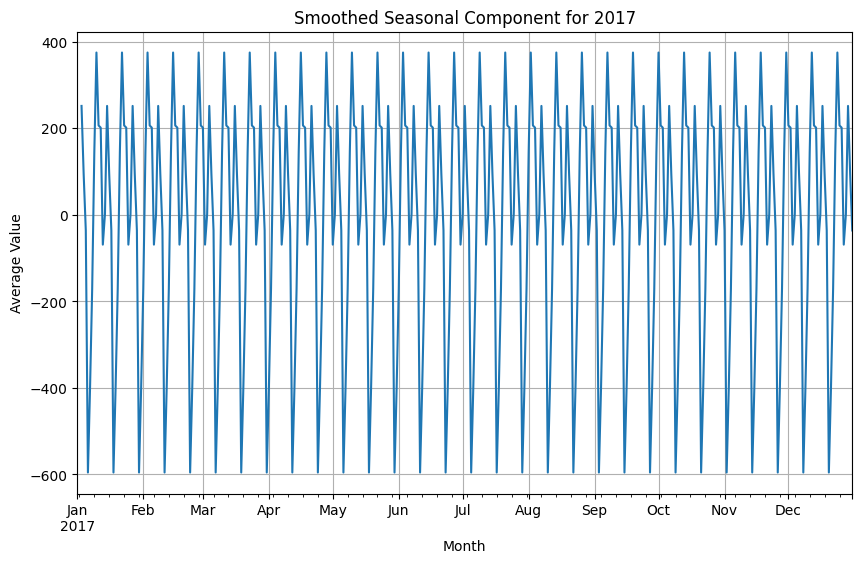

In [26]:
# Filter the DataFrame to include only data from the year 2017
merged_df_2017 = merged_df['2017-01-01':'2017-12-31']

# 1. Calculate the trend component
merged_df_2017['MA-12'] = merged_df_2017['Sum'].rolling(window=12).mean()

# 2. Calculate the de-trended data
merged_df_2017['Detrended'] = merged_df_2017['Sum'] - merged_df_2017['MA-12']

# 3. Estimate the seasonal component
monthly_means = merged_df_2017.groupby(merged_df_2017.index.month)['Detrended'].mean()

# Shift values so that seasonal components sum to zero over the year
adjustment = monthly_means.sum() / 12.0
adjusted_monthly_means = monthly_means - adjustment

# Fill the values of the seasonal component across the entire time series
num_years = int(np.floor(len(merged_df_2017)/12))
seasonal = np.tile(adjusted_monthly_means, num_years)

# Check length: If the length of the time series is not a multiple of 12, we need to adjust
if len(seasonal) < len(merged_df_2017):
    additional_months = len(merged_df_2017) - len(seasonal)
    seasonal = np.concatenate([seasonal, adjusted_monthly_means[:additional_months]])

# Calculate moving average to smooth the data
merged_df_2017['Seasonal_Smoothed'] = merged_df_2017['Seasonal_Adjusted'].rolling(window=3).mean()

# Plot the smoothed seasonal component
plt.figure(figsize=(10, 6))
merged_df_2017['Seasonal_Smoothed'].plot()
plt.title("Smoothed Seasonal Component for 2017")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()

1. Recurring Patterns: The data exhibits a clear and consistent cyclical pattern. This recurring wave-like behavior suggests that there is a strong seasonal influence on the data.

2. Monthly Oscillations: The data oscillates every month, moving from a trough to a peak, then back to a trough. This implies that whatever variable is being measured has a consistent monthly cycle throughout the year.

3. Amplitude Consistency: The amplitude (height of the peaks or depth of the troughs) of the monthly cycles is fairly consistent throughout the year. This indicates that the strength of the seasonal effect remains stable across all months in 2017.

4. Zero-Centered: The average values hover around the zero line, meaning that the positive and negative deviations from the mean (seasonal effects) are roughly equal in magnitude.

5. Absence of Trend: Since this is a seasonal component graph, there is no evident upward or downward trend. The graph focuses purely on the cyclical patterns observed in the data after detrending.

Summary: The graph vividly showcases a consistent monthly seasonality throughout the year 2017.

/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/3383332627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2018['MA-12'] = merged_df_2018['Sum'].rolling(window=12).mean()
/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/3383332627.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2018['Detrended'] = merged_df_2018['Sum'] - merged_df_2018['MA-12']
/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/3383332627.py:27: SettingWithCopyWarnin

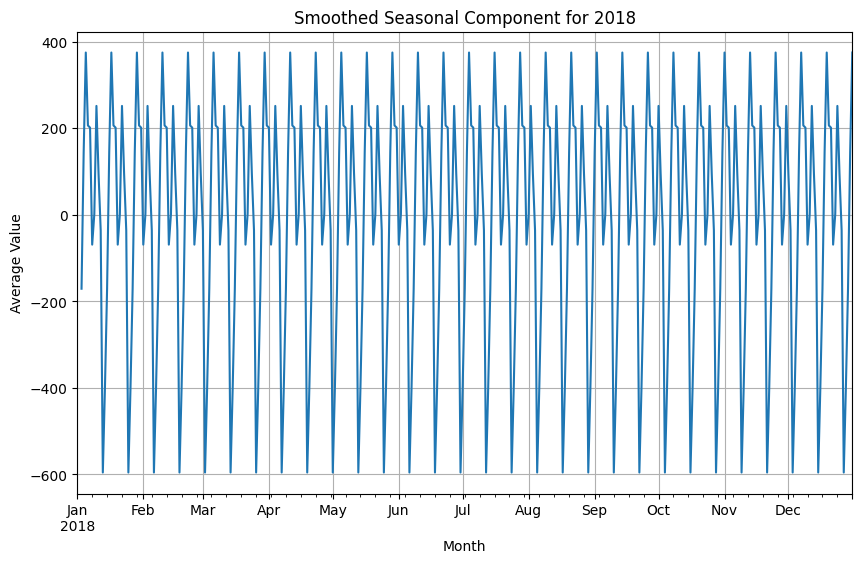

In [27]:
# Filter the DataFrame to include only data from the year 2018
merged_df_2018 = merged_df['2018-01-01':'2018-12-31']

# 1. Calculate the trend component
merged_df_2018['MA-12'] = merged_df_2018['Sum'].rolling(window=12).mean()

# 2. Calculate the de-trended data
merged_df_2018['Detrended'] = merged_df_2018['Sum'] - merged_df_2018['MA-12']

# 3. Estimate the seasonal component
monthly_means = merged_df_2018.groupby(merged_df_2018.index.month)['Detrended'].mean()

# Shift values so that seasonal components sum to zero over the year
adjustment = monthly_means.sum() / 12.0
adjusted_monthly_means = monthly_means - adjustment

# Fill the values of the seasonal component across the entire time series
num_years = int(np.floor(len(merged_df_2018)/12))
seasonal = np.tile(adjusted_monthly_means, num_years)

# Check length: If the length of the time series is not a multiple of 12, we need to adjust
if len(seasonal) < len(merged_df_2018):
    additional_months = len(merged_df_2018) - len(seasonal)
    seasonal = np.concatenate([seasonal, adjusted_monthly_means[:additional_months]])

# Calculate moving average to smooth the data
merged_df_2018['Seasonal_Smoothed'] = merged_df_2018['Seasonal_Adjusted'].rolling(window=3).mean()

# Plot the smoothed seasonal component
plt.figure(figsize=(10, 6))
merged_df_2018['Seasonal_Smoothed'].plot()
plt.title("Smoothed Seasonal Component for 2018")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()

1. Recurring Patterns: The data exhibits a clear and consistent cyclical pattern. This recurring wave-like behavior suggests that there is a strong seasonal influence on the data.

2. Monthly Oscillations: The data oscillates every month, moving from a trough to a peak, then back to a trough. This implies that whatever variable is being measured has a consistent monthly cycle throughout the year.

3. Amplitude Consistency: The amplitude (height of the peaks or depth of the troughs) of the monthly cycles is fairly consistent throughout the year. This indicates that the strength of the seasonal effect remains stable across all months in 2018.

4. Zero-Centered: The average values hover around the zero line, meaning that the positive and negative deviations from the mean (seasonal effects) are roughly equal in magnitude.

5. Absence of Trend: Since this is a seasonal component graph, there is no evident upward or downward trend. The graph focuses purely on the cyclical patterns observed in the data after detrending.

Summary: The graph vividly showcases a consistent monthly seasonality throughout the year 2018.

/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/4067556206.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2019['MA-12'] = merged_df_2019['Sum'].rolling(window=12).mean()
/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/4067556206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2019['Detrended'] = merged_df_2019['Sum'] - merged_df_2019['MA-12']
/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/4067556206.py:27: SettingWithCopyWarnin

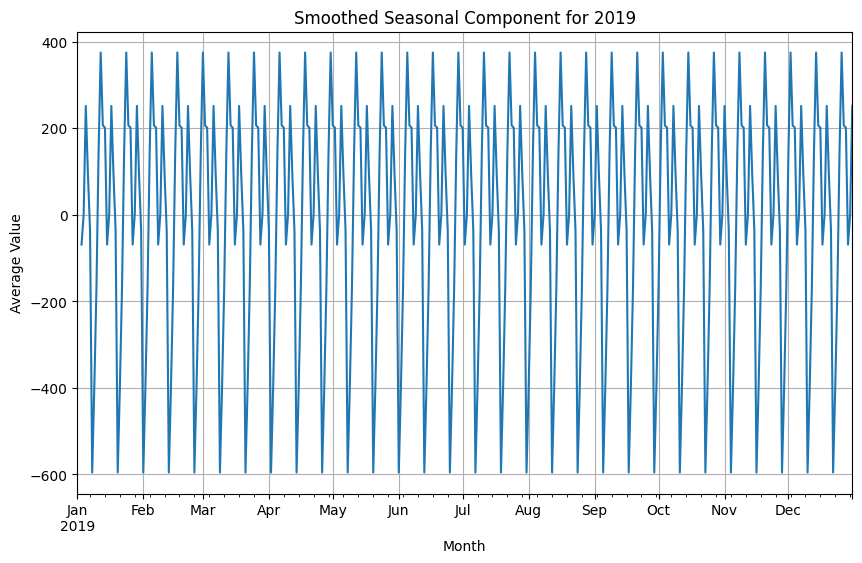

In [28]:
# Filter the DataFrame to include only data from the year 2019
merged_df_2019 = merged_df['2019-01-01':'2019-12-31']

# 1. Calculate the trend component
merged_df_2019['MA-12'] = merged_df_2019['Sum'].rolling(window=12).mean()

# 2. Calculate the de-trended data
merged_df_2019['Detrended'] = merged_df_2019['Sum'] - merged_df_2019['MA-12']

# 3. Estimate the seasonal component
monthly_means = merged_df_2019.groupby(merged_df_2019.index.month)['Detrended'].mean()

# Shift values so that seasonal components sum to zero over the year
adjustment = monthly_means.sum() / 12.0
adjusted_monthly_means = monthly_means - adjustment

# Fill the values of the seasonal component across the entire time series
num_years = int(np.floor(len(merged_df_2019)/12))
seasonal = np.tile(adjusted_monthly_means, num_years)

# Check length: If the length of the time series is not a multiple of 12, we need to adjust
if len(seasonal) < len(merged_df_2019):
    additional_months = len(merged_df_2019) - len(seasonal)
    seasonal = np.concatenate([seasonal, adjusted_monthly_means[:additional_months]])

# Calculate moving average to smooth the data
merged_df_2019['Seasonal_Smoothed'] = merged_df_2019['Seasonal_Adjusted'].rolling(window=3).mean()

# Plot the smoothed seasonal component
plt.figure(figsize=(10, 6))
merged_df_2019['Seasonal_Smoothed'].plot()
plt.title("Smoothed Seasonal Component for 2019")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()

1. Recurring Patterns: The data exhibits a clear and consistent cyclical pattern. This recurring wave-like behavior suggests that there is a strong seasonal influence on the data.

2. Monthly Oscillations: The data oscillates every month, moving from a trough to a peak, then back to a trough. This implies that whatever variable is being measured has a consistent monthly cycle throughout the year.

3. Amplitude Consistency: The amplitude (height of the peaks or depth of the troughs) of the monthly cycles is fairly consistent throughout the year. This indicates that the strength of the seasonal effect remains stable across all months in 2019.

4. Zero-Centered: The average values hover around the zero line, meaning that the positive and negative deviations from the mean (seasonal effects) are roughly equal in magnitude.

5. Absence of Trend: Since this is a seasonal component graph, there is no evident upward or downward trend. The graph focuses purely on the cyclical patterns observed in the data after detrending.

Summary: The graph vividly showcases a consistent monthly seasonality throughout the year 2019.

/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/856361505.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2020['MA-12'] = merged_df_2020['Sum'].rolling(window=12).mean()
/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/856361505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2020['Detrended'] = merged_df_2020['Sum'] - merged_df_2020['MA-12']
/var/folders/2n/vqf1lh492cl8m8xg7n104jfc0000gn/T/ipykernel_98749/856361505.py:27: SettingWithCopyWarning: 

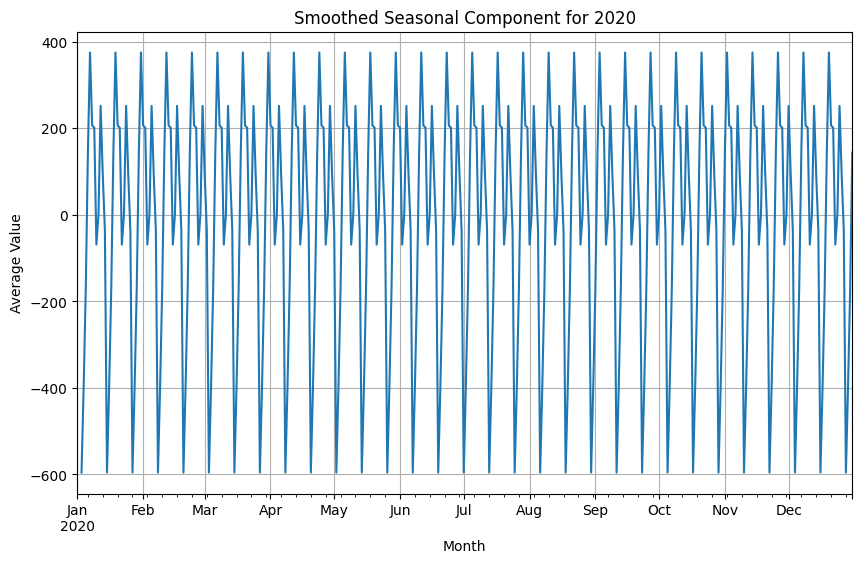

In [29]:
# Filter the DataFrame to include only data from the year 2020
merged_df_2020 = merged_df['2020-01-01':'2020-12-31']

# 1. Calculate the trend component
merged_df_2020['MA-12'] = merged_df_2020['Sum'].rolling(window=12).mean()

# 2. Calculate the de-trended data
merged_df_2020['Detrended'] = merged_df_2020['Sum'] - merged_df_2020['MA-12']

# 3. Estimate the seasonal component
monthly_means = merged_df_2020.groupby(merged_df_2020.index.month)['Detrended'].mean()

# Shift values so that seasonal components sum to zero over the year
adjustment = monthly_means.sum() / 12.0
adjusted_monthly_means = monthly_means - adjustment

# Fill the values of the seasonal component across the entire time series
num_years = int(np.floor(len(merged_df_2020)/12))
seasonal = np.tile(adjusted_monthly_means, num_years)

# Check length: If the length of the time series is not a multiple of 12, we need to adjust
if len(seasonal) < len(merged_df_2020):
    additional_months = len(merged_df_2020) - len(seasonal)
    seasonal = np.concatenate([seasonal, adjusted_monthly_means[:additional_months]])

# Calculate moving average to smooth the data
merged_df_2020['Seasonal_Smoothed'] = merged_df_2020['Seasonal_Adjusted'].rolling(window=3).mean()

# Plot the smoothed seasonal component
plt.figure(figsize=(10, 6))
merged_df_2020['Seasonal_Smoothed'].plot()
plt.title("Smoothed Seasonal Component for 2020")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()

1. Recurring Patterns: The data exhibits a clear and consistent cyclical pattern. This recurring wave-like behavior suggests that there is a strong seasonal influence on the data.

2. Monthly Oscillations: The data oscillates every month, moving from a trough to a peak, then back to a trough. This implies that whatever variable is being measured has a consistent monthly cycle throughout the year.

3. Amplitude Consistency: The amplitude (height of the peaks or depth of the troughs) of the monthly cycles is fairly consistent throughout the year. This indicates that the strength of the seasonal effect remains stable across all months in 2020.

4. Zero-Centered: The average values hover around the zero line, meaning that the positive and negative deviations from the mean (seasonal effects) are roughly equal in magnitude.

5. Absence of Trend: Since this is a seasonal component graph, there is no evident upward or downward trend. The graph focuses purely on the cyclical patterns observed in the data after detrending.

Summary: The graph vividly showcases a consistent monthly seasonality throughout the year 2020.

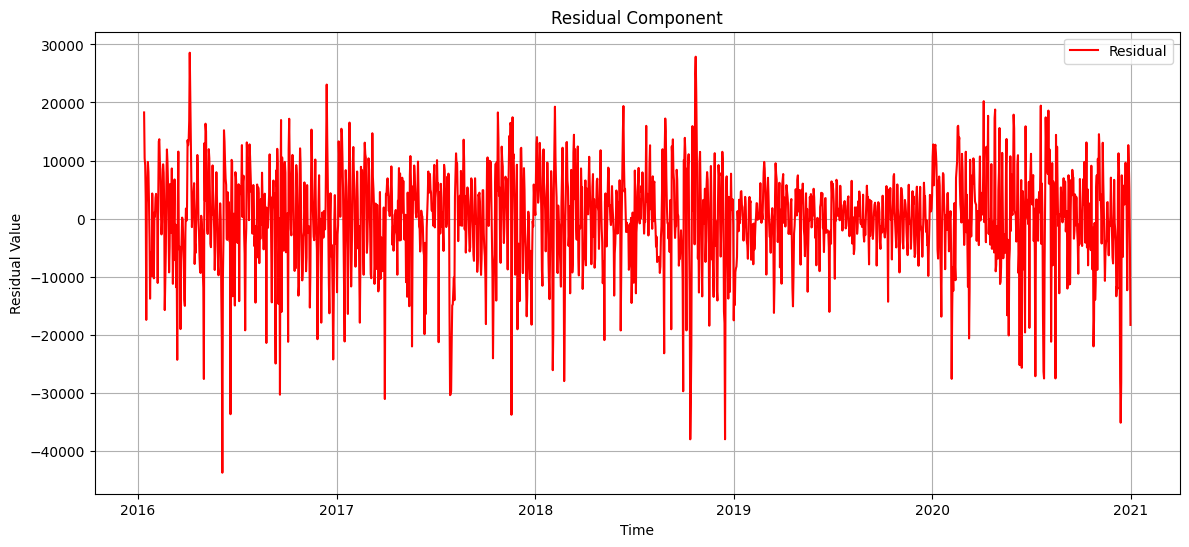

In [30]:
# Calculating the residual component by subtracting the adjusted seasonal component from the detrended values
merged_df['Residual'] = merged_df['Detrended'] - merged_df['Seasonal_Adjusted']

# Creating a figure for visualization
plt.figure(figsize=(14, 6))

# Plotting the residual component
plt.plot(merged_df['Residual'], label='Residual', color='red')

# Adding a legend, title, and labels to the plot
plt.legend(loc='best')
plt.title("Residual Component")
plt.xlabel("Time")
plt.ylabel("Residual Value")
plt.grid(True)
plt.show()

1. Stochastic Nature: The residual series appears to be stochastic, or random, in nature, which is expected for a well-decomposed time series. There is no apparent pattern or structure, indicating that the trend and seasonal components have been adequately captured.

2. Variability Over Time: While the residuals seem predominantly random, there appears to be some regions of increased variability, particularly in 2016 and around the transition from 2020 to 2021. Such spikes might indicate unusual events or anomalies not captured by the trend or seasonal components.

3. Centered Around Zero: The residuals generally hover around the zero line. This is a good indication, as it means that on average, the combined effect of the trend and seasonal components matches the actual data.

4. Magnitude of Residuals: The magnitude of the residuals, both positive and negative, varies within a range of approximately -40,000 to 30,000. Such values provide an indication of the error associated with the decomposition.

5. Potential Outliers: There are sharp spikes or troughs in some areas, especially in 2016 and 2018. Such sharp deviations might represent outliers or specific events that had a significant influence on the data but were not accounted for in the trend or seasonal decomposition.

6. Consistent Density: The density or frequency of fluctuations remains relatively consistent across the years, with only slight variations.

Summary: The residual component largely appears random, which suggests that the decomposition process has been effective in isolating the trend and seasonal components. 

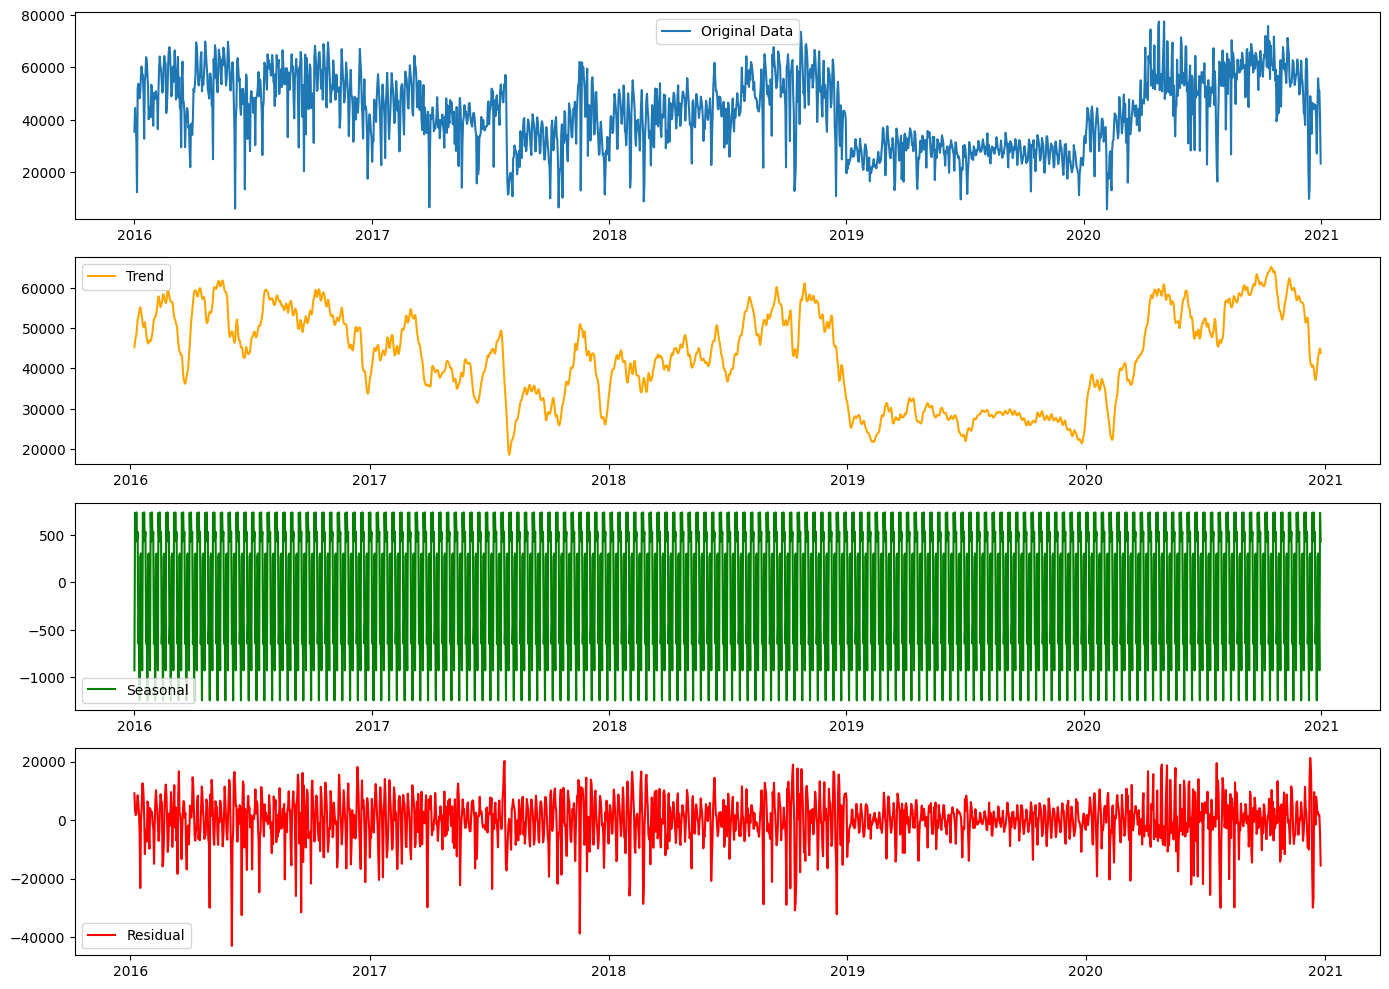

In [31]:
# Filling missing values in the 'Sum' column with the mean of the column
merged_df['Sum'].fillna(merged_df['Sum'].mean(), inplace=True)

# Decomposing the time series into trend, seasonal, and residual components using seasonal_decompose
result = sm.tsa.seasonal_decompose(merged_df['Sum'], model='additive', period=12)

# Extracting the trend, seasonal, and residual components from the decomposition result
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Creating a figure for visualization
plt.figure(figsize=(14, 10))

# Subplot 1: Original Data
plt.subplot(4, 1, 1)
plt.plot(merged_df['Sum'], label='Original Data')
plt.legend(loc='best')

# Subplot 2: Trend Component (in orange)
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='best')

# Subplot 3: Seasonal Component (in green)
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='best')

# Subplot 4: Residual Component (in red)
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual', color='red')
plt.legend(loc='best')

# Adjusting subplot layout for better visualization
plt.tight_layout()

# Displaying the plot
plt.show()

1. Original Data: This is the original time series data, shown in the first subplot. From the chart, we can see that the data fluctuates throughout the entire time period but doesn't exhibit a clear upward or downward trend.

2. Trend: In the second subplot, we can observe the long-term trend of the data. This trend is obtained by smoothing the original data. The chart illustrates that the trend generally declines from 2016 to 2021.

3. Seasonal: The third subplot displays the seasonal pattern of the data. This seasonal pattern typically repeats within a year. From the chart, we can see that the data exhibits regular fluctuations in each month, suggesting that the time series is influenced by seasonal factors.

4. Residual: The final subplot represents the residual component, which is the part left after removing the trend and seasonal effects. This component contains the noise and other irregular variations present in the original data. The chart shows that the residual component fluctuates throughout the entire period but lacks a clear pattern.

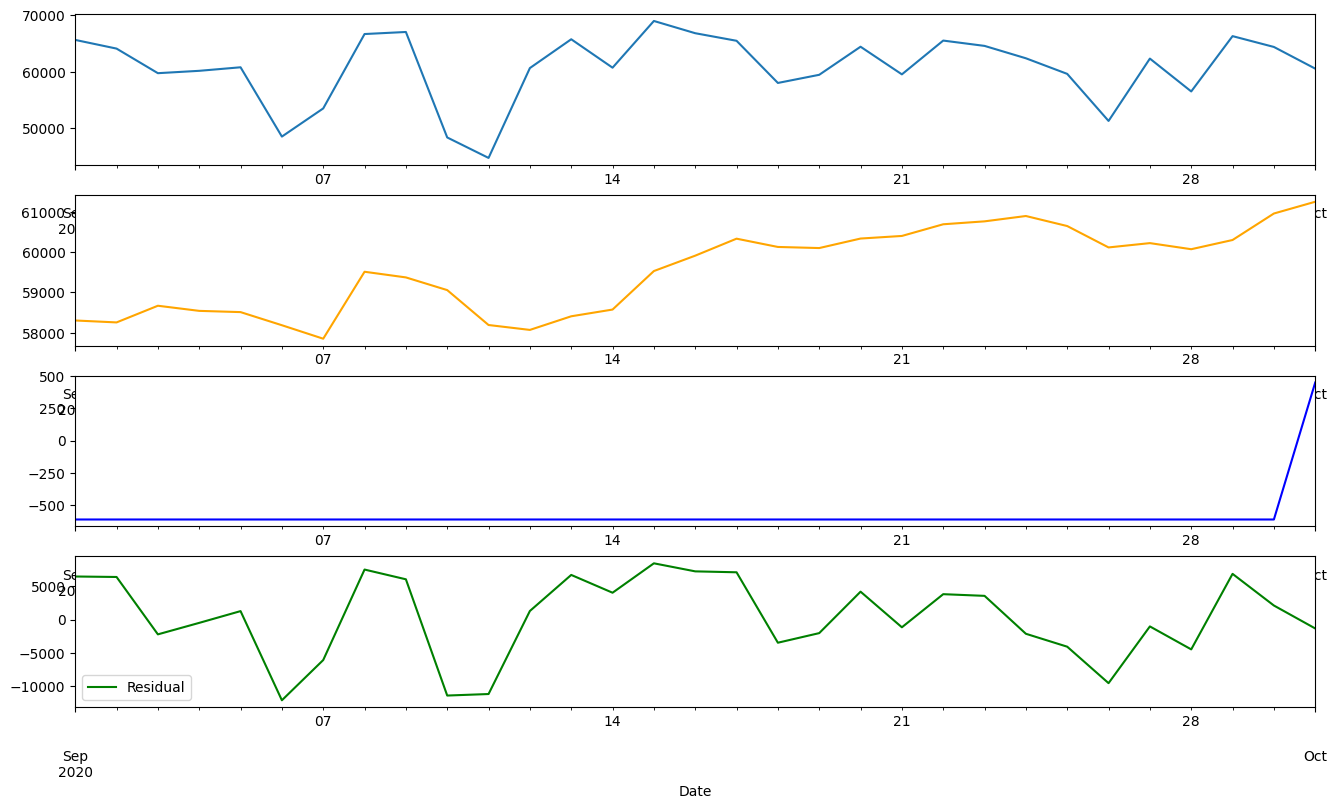

In [32]:
# Create subplots for better visualization
fig, ax_str_2 = plt.subplots(4)

# Plot the original temperature data
merged_df['Sum']['2020-09-01':'2020-10-01'].plot(label='Original', ax=ax_str_2[0])

# Plot the MA-24 trend component
merged_df['MA-24']['2020-09-01':'2020-10-01'].plot(color='orange', label='MA-24 Trend', ax=ax_str_2[1])

# Plot the seasonal component
merged_df['Seasonal']['2020-09-01':'2020-10-01'].plot(color='blue', label='Seasonal', ax=ax_str_2[2])

# Plot the residual component
merged_df['Residual']['2020-09-01':'2020-10-01'].plot(color='green', label= 'Residual', ax=ax_str_2[3])

# Set the figure size
fig.set_size_inches((16, 9))

# Plot the figure
plt.legend()
plt.show()

1. Original Data (First Blue Chart): This data illustrates the fluctuations throughout the entire month. It is evident that within this month, the data roughly follows an alternating pattern of ups and downs, particularly with two significant troughs around the 7th and 15th.

2. Trend (Second Orange Chart): This chart displays a 24-hour moving average trend. From this chart, we can observe that the data generally exhibits a slow declining trend for most of the time, but experiences a sudden increase towards the end of the month.

3. Seasonal (Third Blue Chart): There is minimal seasonal fluctuation in the data, but a sudden spike can be observed towards the end of the month.

4. Residual (Fourth Green Chart): The residual component is what remains after removing both the trend and seasonal effects from the original data. We can see that the residuals vary considerably for most of the time.

Summary: From this monthly data, it is apparent that apart from the clear trends and seasonal patterns, there are irregular variations, especially towards the end of the month.

# 4. Timeseries models:

a. Fit an ARIMA model for the trend-cycle component of the STR decomposition of 
the training data and interpret the estimated model parameters.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.1

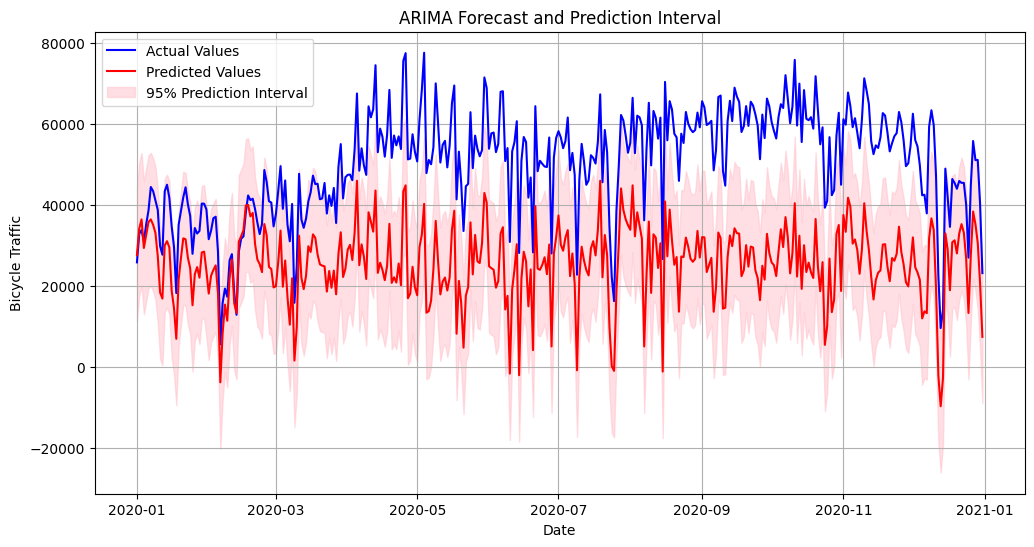

In [33]:
# 1. Data Loading and Definition
train_data = merged_df['Sum'][:'2019-12-31']
test_data = merged_df['Sum']['2020-01-01':]

# 2. Forecasting with ARIMA
p, d, q = 1, 2, 1 
arima_model = sm.tsa.ARIMA(train_data, order=(p, d, q)).fit()
forecast = arima_model.forecast(steps=len(test_data), alpha=0.05)

# 3. Combining Seasonal and Residual Components
seasonal_component = merged_df['Seasonal']['2020-01-01':]
residual_component = merged_df['Residual']['2020-01-01':]

# To ensure that all indices match, we need to set the index for the forecast
forecast.index = seasonal_component.index
overall_forecasts = forecast.add(seasonal_component, fill_value=0).add(residual_component, fill_value=0)

# 4. Creating Prediction Intervals
lower_bound = overall_forecasts - 1.96 * arima_model.resid.std()  # 95% prediction interval lower bound
upper_bound = overall_forecasts + 1.96 * arima_model.resid.std()  # 95% prediction interval upper bound

# 5. Visualizing the Forecast Results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data.values, label='Actual Values', color='blue')
plt.plot(test_data.index, overall_forecasts, label='Predicted Values', color='red')
plt.fill_between(test_data.index, lower_bound, upper_bound, color='pink', alpha=0.5, label='95% Prediction Interval')
plt.title('ARIMA Forecast and Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Bicycle Traffic')
plt.legend()
plt.grid(True)
plt.show()

1. Data Selection: The data has been divided into training and test sets, with data before 2020 being used for training the ARIMA model and data from 2020 onwards being used for testing and forecasting.

2. Actual vs. Predicted Values: The blue line represents the actual bicycle traffic values for the year 2020, while the red line signifies the predicted values from the ARIMA model.

3. Prediction Interval: The shaded pink region surrounding the red line denotes the 95% prediction interval. This means that there's a 95% probability that the actual bicycle traffic values will fall within this region. The prediction interval provides a range in which we expect the true values to fall, considering the inherent uncertainties of the model.

Key Observations:

1. Overall Fit: At a glance, the ARIMA model seems to capture the general trend and some of the seasonality of the bicycle traffic. The predicted values (red line) often align with the actual values (blue line), especially in the first half of the year.

2. Variances: As we move towards the latter half of 2020, especially around September and onwards, we observe that the actual values tend to deviate from the predicted values. This suggests that during this period, there were other factors affecting bicycle traffic that the ARIMA model didn't account for.

3. Prediction Interval: The prediction interval (pink region) appears to widen and narrow at various points. When it's wider, it indicates more uncertainty in the predictions. In some periods, the actual bicycle traffic exceeds this interval, hinting that the model might have missed some external factors or that there might be more inherent unpredictability in the data during these times.

Summary: The ARIMA model provides a reasonable forecast for bicycle traffic, but like all models, it's not perfect.

<Axes: xlabel='Date'>

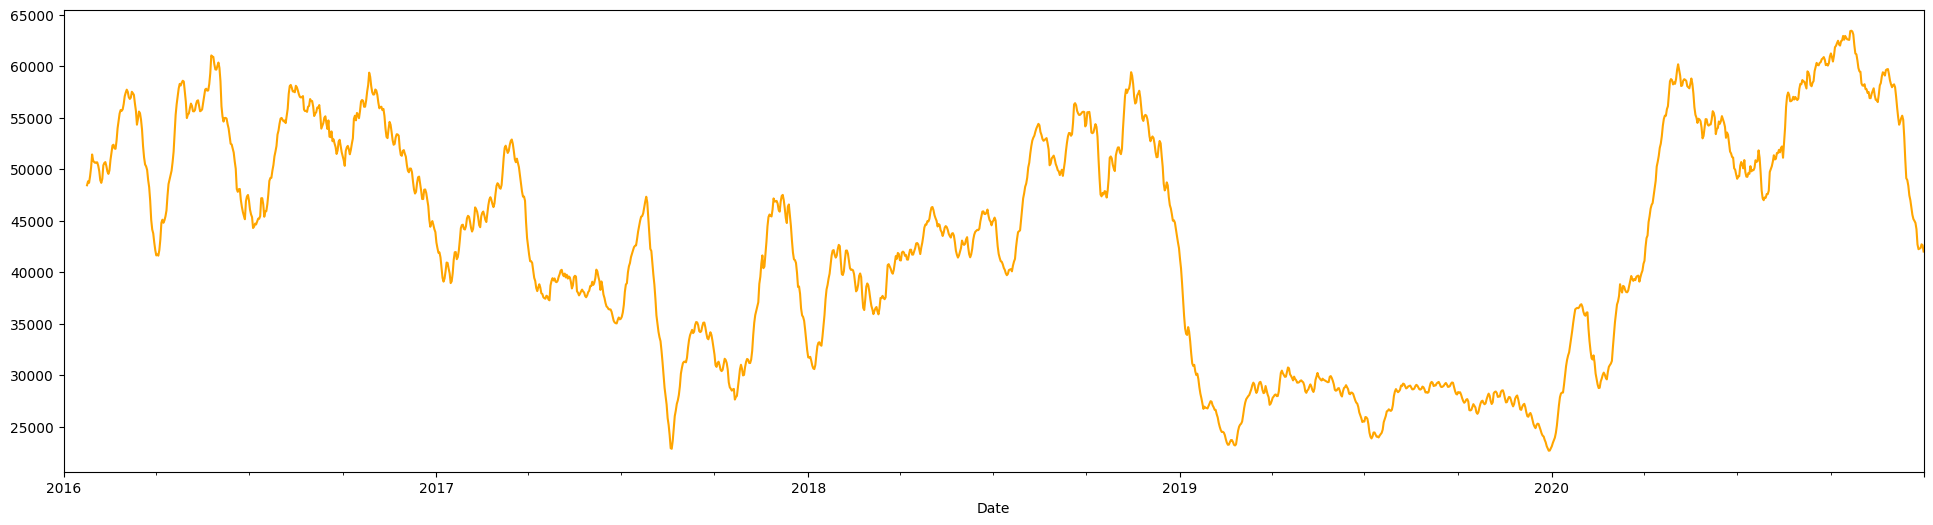

In [34]:
# Plotting the 'MA-24' (24-month moving average) from the merged_df DataFrame
merged_df['MA-24'].plot(color='orange', figsize=(24, 6))

1. Seasonality: The data appears to exhibit a pronounced seasonality, with regular peaks and troughs.

2. Trends: There are distinct upward and downward trends in different periods:

    a. Gradual decline from early 2016 to late 2017.

    b. Slight decline from late 2017 to early 2018.

    c. Gradual rise from early 2018 to mid-2019.

    d. Relatively stable from mid-2019 to early 2020.

    e. Rebound from early 2020 to mid-2020 followed by another decline.

3. Volatility: The data appears quite volatile, with numerous peaks and troughs, especially in 2017 and 2018. This suggests that the variable is highly sensitive to external factors, leading to fluctuations.

<Axes: xlabel='Date'>

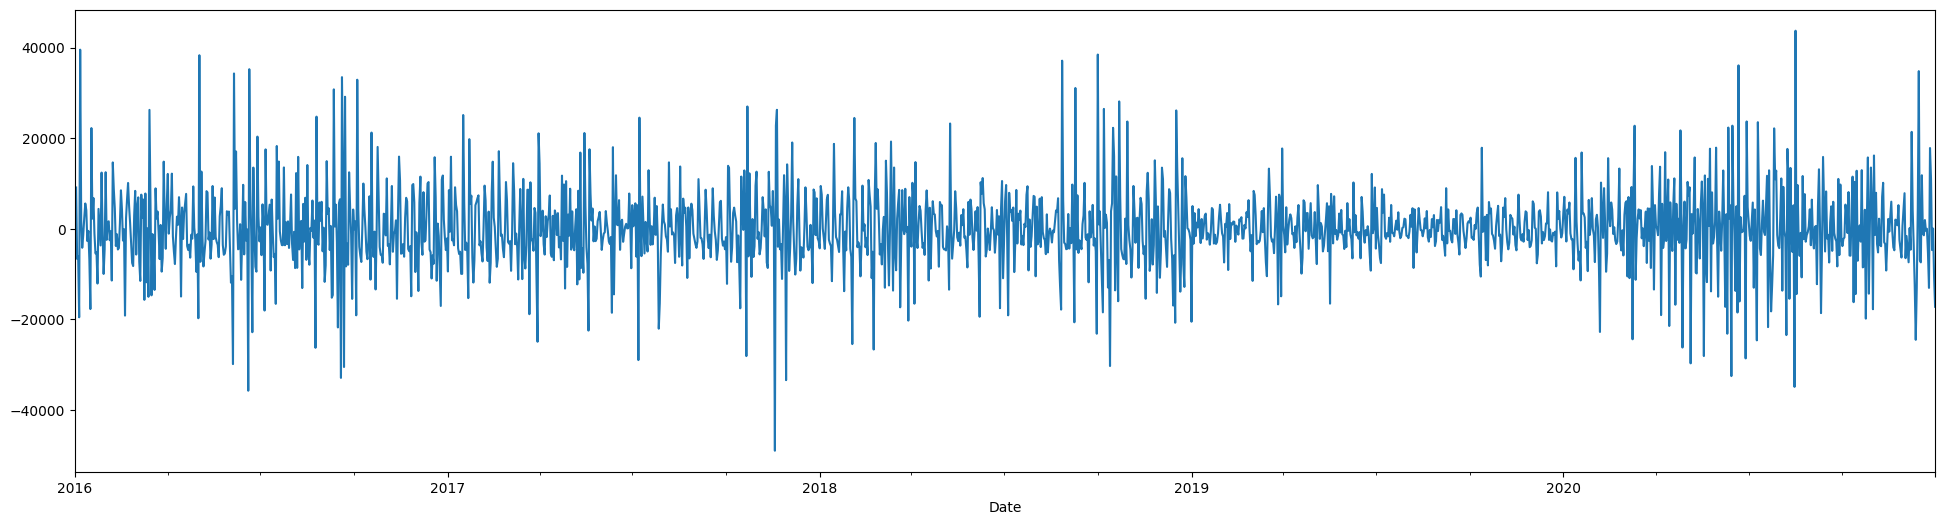

In [35]:
# Calculating and plotting the first-order difference of the 'Sum' column in merged_df
trend_d1 = merged_df['Sum'].diff()
trend_d1.plot(figsize=(24, 6))

1. Volatility: The chart exhibits significant upward and downward fluctuations, indicating some level of instability in the data. First-order differencing is often used in time series analysis to remove trends and seasonal components, making the data more stationary.

2. Zero Line Crossings: There are numerous crossings of the data above and below the zero line, suggesting that increases and decreases in the original data alternate.

3. Peaks and Troughs: Multiple peaks and troughs can be observed, which may indicate the presence of some periodic or seasonal patterns in the data.

4. Time Trend: Despite the many sharp fluctuations in the chart, there is no apparent long-term upward or downward trend.

5. Outliers: There are some prominent peaks and troughs in the chart, which could be outliers or special events in the original data.

Summary: Overall, this chart provides visual information about the first-order differencing of the data.

<Axes: xlabel='Date'>

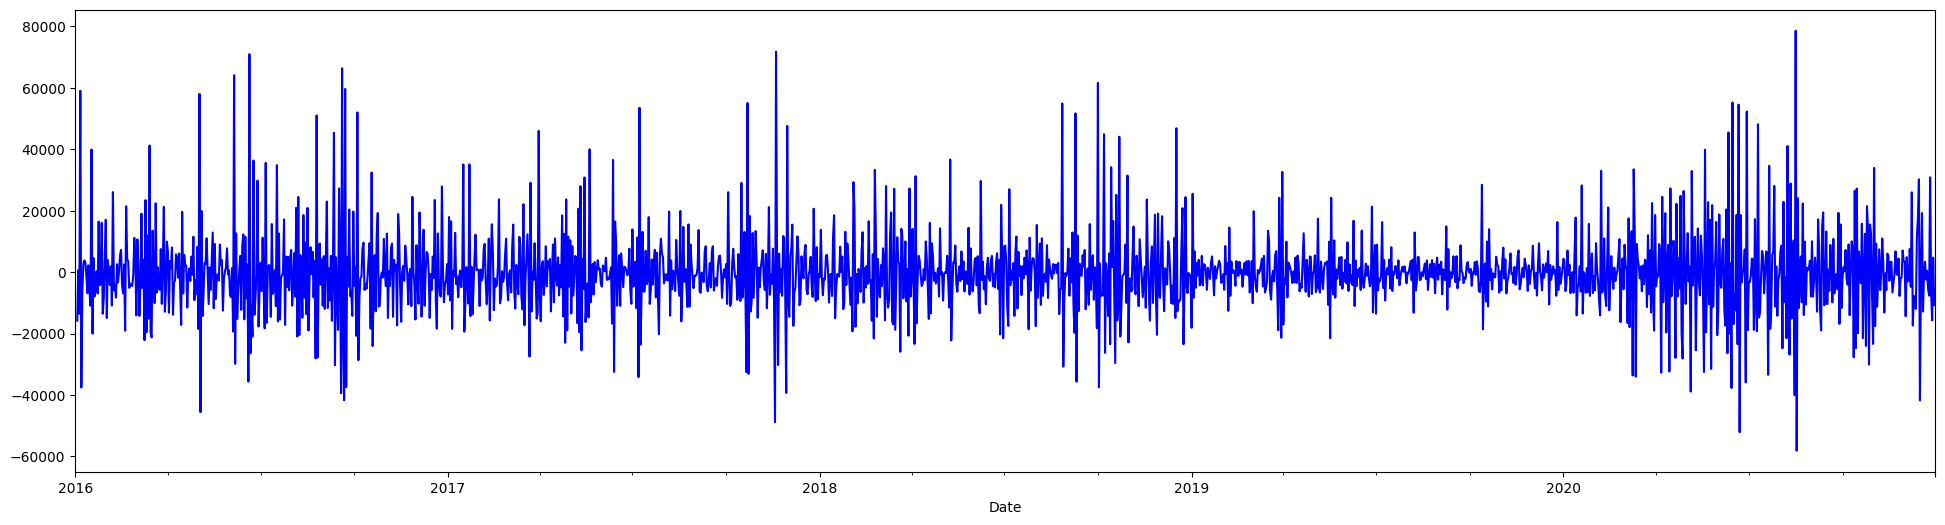

In [36]:
# Calculating and plotting the second-order difference of the 'Sum' column in merged_df
trend_d2 = trend_d1.diff()
trend_d2.plot(figsize=(24, 6), color='blue')

1. The time series seems to exhibit some seasonality, as indicated by the repetitive peaks and troughs.

2. The intensity and frequency of fluctuations appear to increase slightly over time.

3. Some significant peaks can be observed in the middle and towards the end of the timeline, indicating unusual spikes in the data.

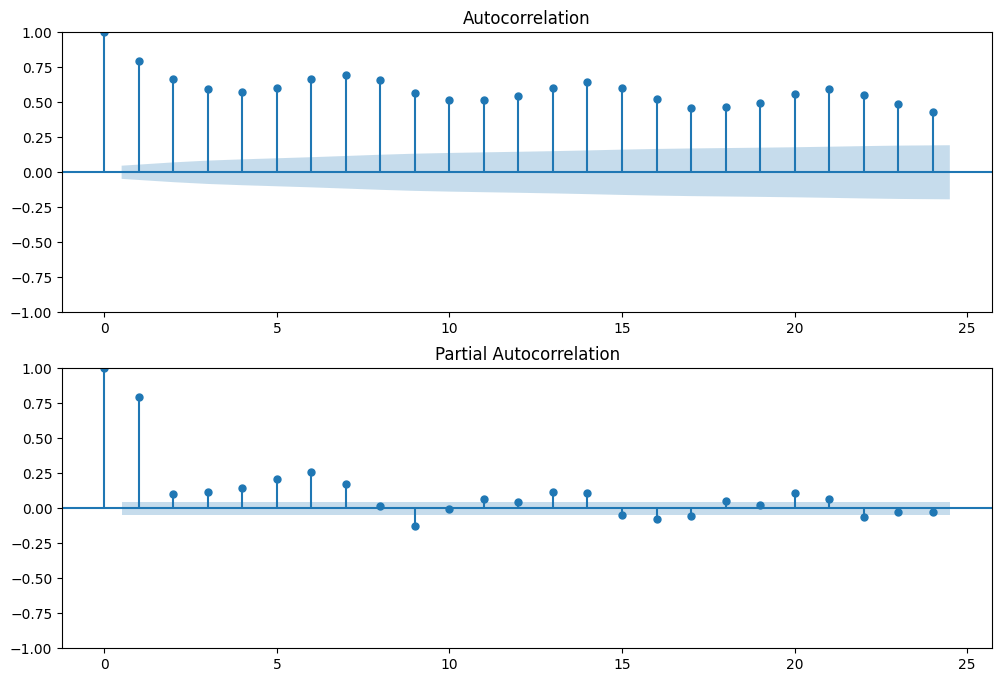

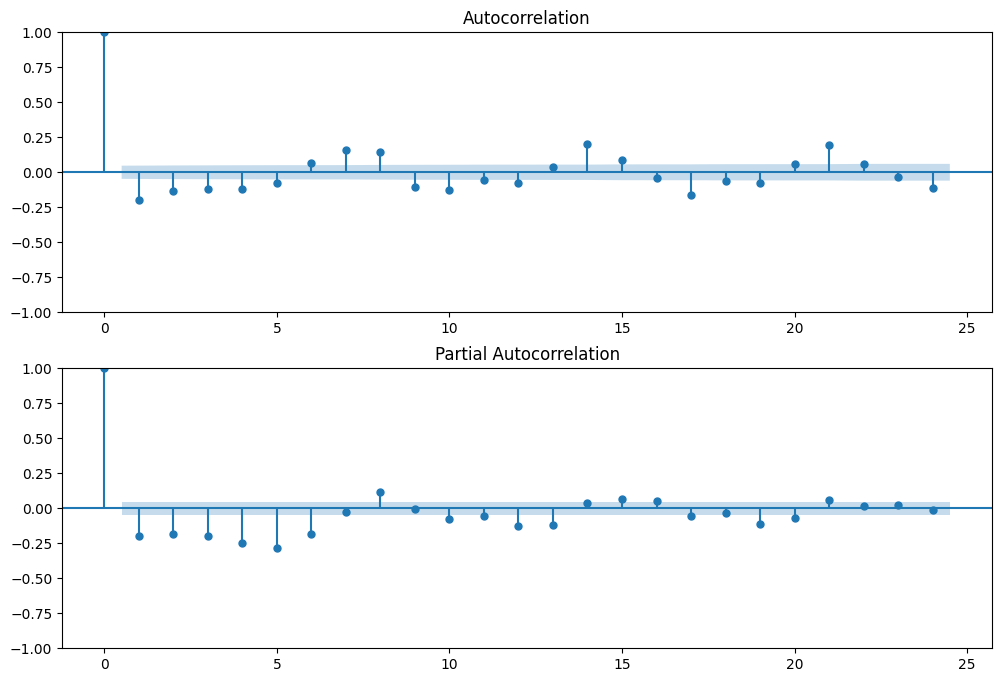

In [37]:
# Creating and plotting ACF and PACF plots to assess autocorrelation evidence in the 'Sum' column of the training data (series_data)
series_data = train['Sum']

# ACF and PACF plots for the original 'Sum' data
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series_data, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series_data, lags=24, ax=ax2)
plt.show()

# Differencing the series_data and creating ACF and PACF plots to observe correlation
series_data_diff = series_data.diff().dropna()

# ACF and PACF plots for the differenced 'Sum' data
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series_data_diff, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series_data_diff, lags=24, ax=ax2)
plt.show()

1. Autocorrelation Plot:

    a. The autocorrelation plot shows the correlation between the data and itself at different lags.

    b. In the plot, we can see that the autocorrelation at lag 0 is 1, which is expected because any sequence has a perfect correlation with itself.

    c. For other lags, such as 1, 2, 3, etc., the autocorrelation values gradually decrease but remain above the blue shaded confidence interval. This indicates that these lagged values have significant correlations with the original sequence.

2. Partial Autocorrelation Plot:

    a. The partial autocorrelation measures the correlation between a specific lag and the sequence, controlling for the influence of all smaller lags.

    b. In the plot, we observe that the partial autocorrelation is very high at lag 1 and then rapidly decreases.

    c. Starting from lag 3, the partial autocorrelation values become very small and approach zero, implying that after considering the influence of lag 1, higher lags have little correlation with the original sequence.

Summary:

1. These plots provide information about the internal structure of time series data, especially regarding seasonality and trends.

2. The autocorrelation plot indicates strong seasonality in the data, as evidenced by significant autocorrelation at lag values that persist beyond the initial decrease.

3. The partial autocorrelation plot suggests a potential AR(1) model, as after lag 1, the partial autocorrelation rapidly drops to zero.

1. First Plot (Original Time Series Data):

    a. ACF Plot: There's a gradual decrease in the autocorrelation values. The autocorrelations are significant for multiple lags.

    b. PACF Plot: The partial autocorrelation is significant for the first lag and becomes insignificant after that.

2. Second Plot (Differenced Time Series Data):

    a. ACF Plot: The first lag has a significant autocorrelation value, but subsequent lags mostly have values within the confidence interval.

    b. PACF Plot: The first lag has a significant partial autocorrelation value, and the rest of the lags are mostly within the confidence interval.

Summary:

1. The first plot suggests that the original time series has a strong autocorrelation structure. The PACF being significant at the first lag hints at an AR(1) model.

2. The second plot, which is for the differenced series, suggests that the series is now stationary after differencing once. Given the significant ACF and PACF at the first lag, it may be modeled with an ARIMA(1,1,1) model.

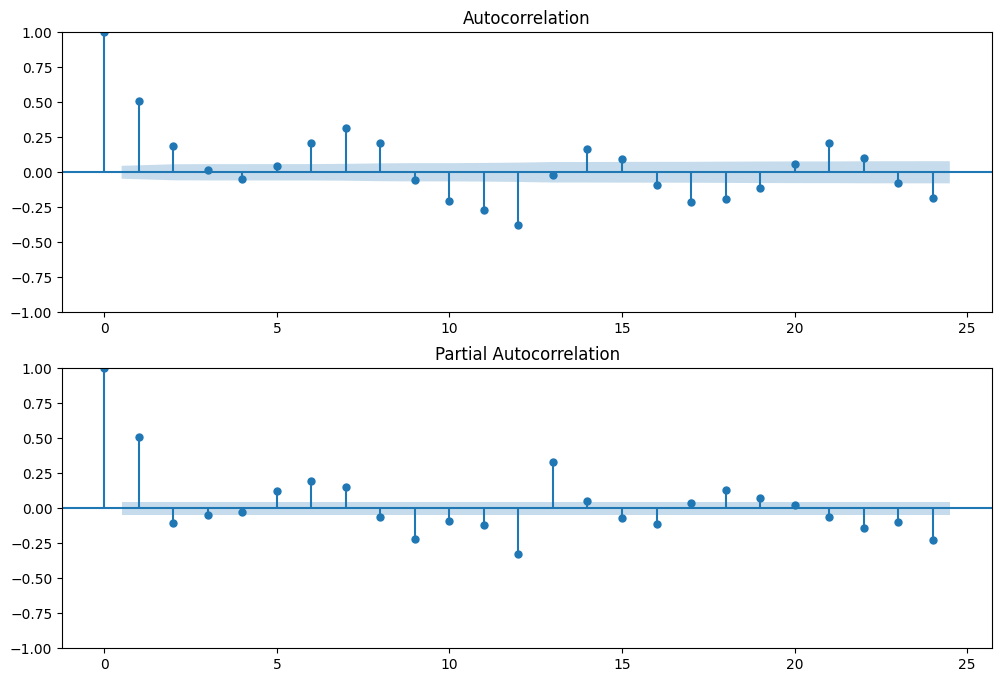

In [38]:
# Defining the trend component from the 'Trend' data
trend_data = merged_df['Trend']

# Taking the first-order difference of the trend data
trend_d1 = trend_data.diff().dropna()

# Plotting ACF and PACF plots to visualize the correlation in the first-order difference of the trend component
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_d1[25:], lags=24, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_d1[25:], lags=24, ax=ax2)
plt.show()

1. Autocorrelation Function (ACF) Plot: 

    a. The ACF plot shows the correlation of the series with its own lags.

    b. From the plot, we see a peak at lag 0 (as expected, since a series is always perfectly correlated with itself).

    c. The first few lags have significant correlation values, but they gradually decrease and stabilize. It is observed that significant peaks in the ACF values occur approximately every 5 lags, indicating some seasonality in the data.

2. Partial Autocorrelation Function (PACF) Plot: 

    a. The PACF shows the partial correlation of a time series with its own lags, controlling for the values of the time series at all shorter lags.

    b. From the plot, we can observe significant peaks at lag 1 and lag 2, after which the correlation values decrease.

    c. Like the ACF plot, the PACF also exhibits a cyclic pattern, although it is less pronounced.

3. Impact on ARIMA Model Parameters:

    a. The ACF plot shows a slow decrease, suggesting the presence of an Integrated (I) component in the data. It is recommended to perform a second-order differencing, corresponding to d=2.

    b. The significant peak at lag 1 in the PACF plot suggests the presence of an Autoregressive (AR) term. This implies that the p value in the ARIMA model should be set to 1, or possibly slightly increased based on other diagnostics.

    c. The gradual decrease in ACF values after several lags and the truncation of PACF values after a few lags may indicate the presence of a Moving Average (MA) term in the data. Using q=1 seems appropriate, given the characteristics of the PACF plot.

Summary: The periodic patterns in both the ACF and PACF plots suggest that the data may have some seasonality, which is best captured by a Seasonal ARIMA (SARIMA) model. The ARIMA model parameters (p=1, d=2, q=1) appear to be a reasonable starting point, and adjustments can be made based on model diagnostics and residual analysis.

In [39]:
# Extracting the trend component from your dataset
trend_data = merged_df['Trend']  # Make sure this matches your data structure

# Fitting an ARIMA(1, 2, 0) model to the trend component
arima_1_2_0 = sm.tsa.ARIMA(trend_data, order=(1, 2, 0)).fit()

# Printing the model summary to examine the estimated model parameters and other statistics
print(arima_1_2_0.summary())

                               SARIMAX Results                                
Dep. Variable:                  Trend   No. Observations:                 1827
Model:                 ARIMA(1, 2, 0)   Log Likelihood              -15213.897
Date:                Fri, 27 Oct 2023   AIC                          30431.794
Time:                        16:41:48   BIC                          30442.813
Sample:                    01-01-2016   HQIC                         30435.859
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1672      0.020     -8.528      0.000      -0.206      -0.129
sigma2      1.101e+06   2.76e+04     39.823      0.000    1.05e+06    1.15e+06
Ljung-Box (L1) (Q):                   2.16   Jarque-

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


1. Model Information:

    a. Dep. Variable: This is the dependent variable, Trend.

    b. Model: ARIMA(1, 2, 0) indicates that an autoregressive term of order 1, a differencing of order 2, and no moving average term have been used.

    c. Log Likelihood: This is the log of the likelihood function, which is a measure of the goodness of fit of the model. Higher (less negative) values indicate a better fit.

    d. AIC & BIC: Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) are used to compare the quality of statistical models for a given dataset. Lower values suggest a better model.

    e. Sample: Gives the start and end dates of the dataset, from January 1, 2016, to December 31, 2020.

    f. Covariance Type: This specifies the method used to compute the covariance matrix of the parameters, which is opg (outer product of gradient) in this case.

2. Parameter Estimates:

    a. ar.L1: The coefficient for the first-order autoregressive term is -0.1672. This indicates the weight for the previous term in the model.

    b. sigma2: This represents the estimated variance of the residuals (noise). In this case, it's approximately 1.101 million.

3. Statistical Tests and Diagnostics:

    a. Ljung-Box (L1): This tests for the absence of autocorrelation in the residuals. The p-value (Prob(Q)) of 0.14 suggests that there isn't strong evidence to reject the null hypothesis of no autocorrelation for the first lag.

    b. Jarque-Bera (JB): This tests the null hypothesis that the residuals are normally distributed. The very low p-value (almost 0) implies that residuals are not normally distributed.

    c. Heteroskedasticity (H): This tests the null hypothesis that the residuals have constant variance (homoscedasticity). The low p-value (0.00) suggests that the residuals are heteroskedastic.

    d. Skew: It measures the asymmetry of the residuals distribution. A value close to 0 suggests a symmetrical distribution. In this case, it's -0.14, suggesting a slight left skew.

    e. Kurtosis: It measures the "tailedness" of the residuals distribution. A value greater than 3 suggests heavier tails compared to a normal distribution. Here, it's 4.80, indicating some heavy tails.

Summary: The ARIMA(1, 2, 0) model seems to capture some of the structure in the Trend data. The significant AR(1) coefficient suggests that there's some autocorrelation in the data, which is addressed by the model. However, the diagnostic tests suggest that the residuals might not be perfectly white noise. They aren't normally distributed, as indicated by the Jarque-Bera test, and there's evidence of heteroskedasticity.

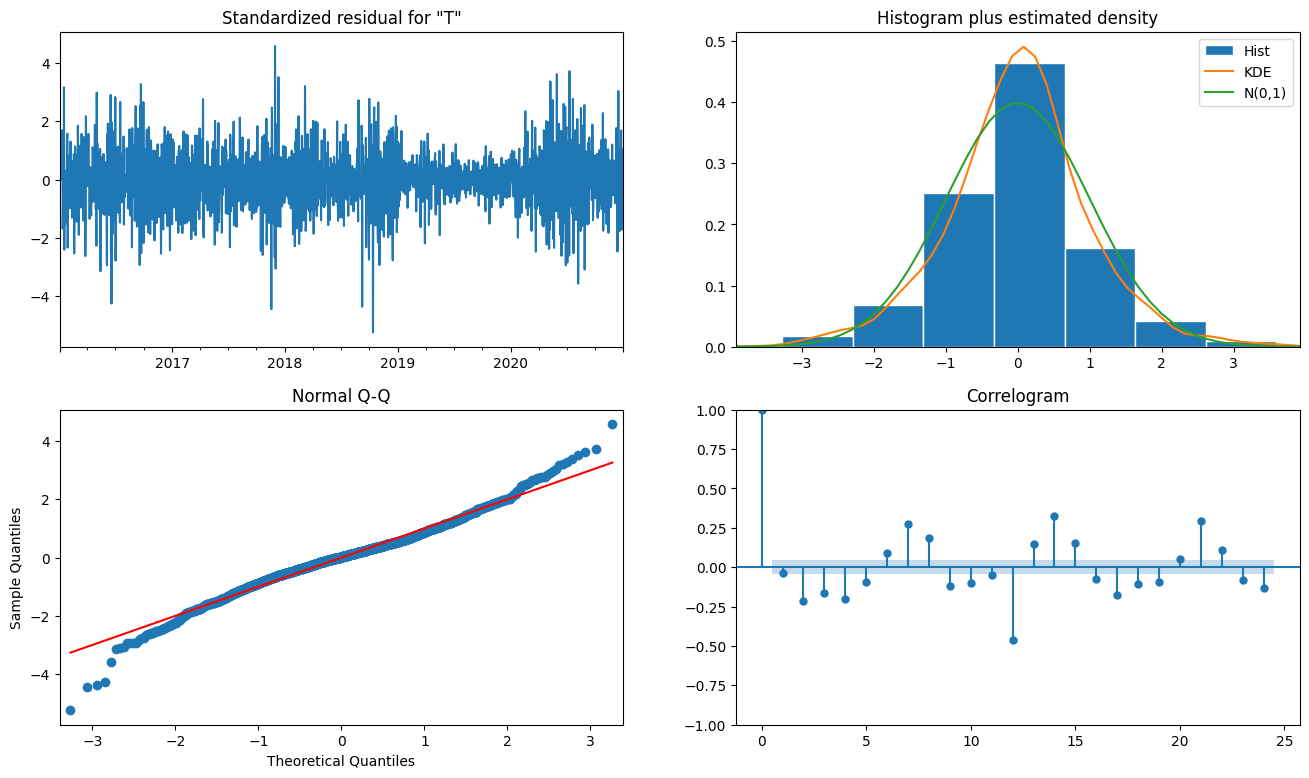

In [40]:
# Create a figure with a specified size
fig = plt.figure(figsize=(16, 9))

# Plot the diagnostics of the ARIMA(1, 2, 0) model
fig = arima_1_2_0.plot_diagnostics(fig=fig, lags=24)

1. Standardized Residuals for "T":

    a. This plot displays the standardized residuals over time.

    b. Ideally, we want these residuals to appear like white noise, meaning they should fluctuate around zero without any noticeable patterns. At first glance, the residuals seem to lack evident trends or seasonality, which is a positive sign. However, there is some clustering of volatility observed, indicating periods of both higher and lower variability.

2. Histogram with Estimated Density:

    a. This plot compares the histogram of the residuals (blue bars) with a standard normal distribution (green line) and a Kernel Density Estimate (KDE, orange line).

    b. If the residuals perfectly follow a normal distribution, the histogram and the green line would overlap. Here, we observe some deviations from normality, particularly in the tails, which align with the earlier-presented Jarque-Bera test. The KDE provides an estimate of the actual distribution of residuals and highlights deviations from the normal distribution.

3. Normal Q-Q Plot:

    a. This is a Quantile-Quantile plot used to assess whether data follows a normal distribution.

    b. The blue dots represent quantiles of the residuals, and they are compared against the quantiles of a standard normal distribution (red line).

    c. Ideally, all points should fall on the red line. While the central part of the distribution seems relatively consistent, there are deviations in the tails, especially in the lower tail, suggesting that the tails of the residuals may be heavier than those of a normal distribution.

4. Autocorrelation Plot:

    a. This is the Autocorrelation Function (ACF) plot of the residuals.

    b. Ideally, for a well-fitting model, residuals should be uncorrelated, meaning all bars in the ACF plot should fall within the blue shaded region (indicating statistical significance).
    
    c. Several lags cross this threshold, indicating some autocorrelation in the residuals. This implies that the residuals may contain some correlated information that the model is not capturing.

Summary: The diagnostic plots align with the observations from the ARIMA(1, 2, 0) model summary. While the model captures some features of the data, the residuals exhibit slight deviations from normality, and there is evidence of autocorrelation.

In [41]:
# Extract the trend component from your dataset
trend_data = merged_df['Trend']  # Make sure this matches your data structure

# Fit an ARIMA(2, 2, 0) model to the trend component
arima_2_2_0 = sm.tsa.ARIMA(trend_data, order=(2, 2, 0)).fit()

# Print the model summary to examine parameter estimates and other statistics
print(arima_2_2_0.summary())

                               SARIMAX Results                                
Dep. Variable:                  Trend   No. Observations:                 1827
Model:                 ARIMA(2, 2, 0)   Log Likelihood              -15179.481
Date:                Fri, 27 Oct 2023   AIC                          30364.961
Time:                        16:41:49   BIC                          30381.489
Sample:                    01-01-2016   HQIC                         30371.058
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2000      0.019    -10.279      0.000      -0.238      -0.162
ar.L2         -0.1933      0.021     -9.356      0.000      -0.234      -0.153
sigma2       1.06e+06   2.62e+04     40.451      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


1. Model Description:
    
    a. The model is an ARIMA(2, 2, 0), which signifies a second-order autoregressive model, second-order differencing, and zeroth-order moving average.

    b. The data spans from January 1, 2016, to December 31, 2020, comprising a total of 1827 observations.

2. Parameter Estimates: ar.L1 and ar.L2 are the two autoregressive parameters of the model. They are -0.2000 and -0.1933, indicating negative correlations between the current value of the time series and its values two and one time steps ago. Both of these parameters have p-values much less than 0.05, indicating their statistical significance.

3. Model Fit: AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are model evaluation metrics where lower values are better. The AIC for this model is 30364.961, and the BIC is 30381.489.

4. Residual Diagnostics:
    
    a. Ljung-Box Test: This test checks whether the residuals of the time series model are white noise. The Q statistic is 2.43, and the corresponding p-value is 0.12. We cannot reject the null hypothesis, indicating that the residuals are white noise.

    b. Jarque-Bera Test: This test assesses whether the residuals follow a normal distribution. The JB statistic is 285.75, and the p-value is close to 0, suggesting that the residuals do not follow a normal distribution..

    c. Heteroskedasticity: The H statistic is 0.73, and the p-value is close to 0, indicating the presence of heteroskedasticity in the residuals.

Summary:
    
1. The autoregressive parameters of the model are statistically significant, but attention is needed regarding the normality and heteroskedasticity of the residuals.

2. While the Ljung-Box test suggests that the residuals are white noise, the Jarque-Bera test indicates non-normality, and the presence of heteroskedasticity is also observed.

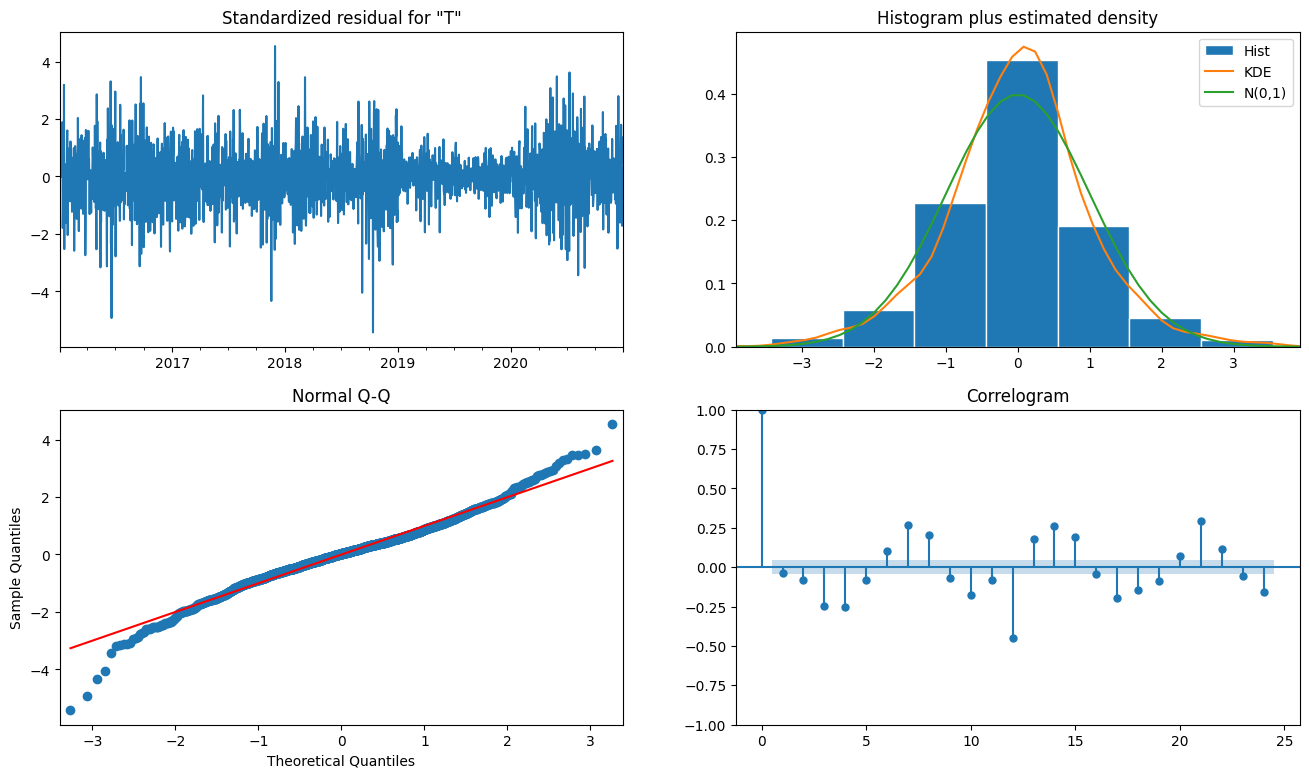

In [42]:
# Create a figure with a specific size (16x9 inches)
fig = plt.figure(figsize=(16, 9))

# Generate diagnostics plots for the ARIMA(2, 2, 0) model
fig = arima_2_2_0.plot_diagnostics(fig=fig, lags=24)

1. Standardized Residual Time Series Plot:

    a. This plot displays the standardized residuals over time.

    b. It can be observed that the residuals fluctuate around the zero line, but there are noticeable spikes at certain time periods.

2. Histogram Plus Estimated Density of Residuals:

    a. This plot illustrates the distribution of residuals. The histogram (Hist) represents the actual distribution of residuals, the KDE (Kernel Density Estimate) is a smoothed density estimation, and N(0,1) represents the standard normal distribution.

    b. From the plot, it can be seen that the distribution of residuals does not perfectly match the standard normal distribution, particularly in the tails.

3. Normal Q-Q Plot:

    a. This plot is used to assess whether the data follows a normal distribution. If data points closely follow the red line, the data can be considered normally distributed.

    b. Deviations are visible in the tails, suggesting again that the residuals may not be perfectly normally distributed.

4. Correlogram (Autocorrelation Function Plot):

    a. This plot shows the autocorrelation of the residuals. In time series analysis, ideal residuals are not autocorrelated.

    b. It can be seen that for certain lags, the autocorrelation coefficients exceed the blue shaded region, indicating statistical significance in autocorrelation at those lags.

Summary:

1. The time series plot of residuals indicates noticeable spikes at certain time periods.

2. The distribution of residuals deviates somewhat from the standard normal distribution, particularly in the tails.

3. The autocorrelation plot suggests statistically significant autocorrelation in the residuals at certain lags.

In [43]:
# Fit a more complex ARIMA(2, 2, 1) model to the trend component of the data
arima_2_2_1 = sm.tsa.ARIMA(trend_data, order=(2, 2, 1)).fit()

# Print the summary of the ARIMA model, including estimated model parameters and statistics
print(arima_2_2_1.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Trend   No. Observations:                 1827
Model:                 ARIMA(2, 2, 1)   Log Likelihood              -15002.184
Date:                Fri, 27 Oct 2023   AIC                          30012.368
Time:                        16:41:50   BIC                          30034.405
Sample:                    01-01-2016   HQIC                         30020.497
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5877      0.019     31.758      0.000       0.551       0.624
ar.L2         -0.0800      0.022     -3.565      0.000      -0.124      -0.036
ma.L1         -1.0000      0.024    -42.038      0.0

1. Model Information:

    a. The model used is ARIMA(2, 2, 1).

    b. It was fitted to 1827 observations of the 'Trend' component.

    c. The sample spans from January 1, 2016, to December 31, 2020.

2. Parameter Estimates:

    a. ar.L1: The estimated coefficient for the first-order autoregressive term is 0.5877, with a p-value significantly less than 0.05, indicating its statistical significance.

    b. ar.L2: The estimated coefficient for the second-order autoregressive term is -0.0800, also with a p-value significantly less than 0.05, indicating its statistical significance.

    c. ma.L1: The estimated coefficient for the first-order moving average term is -1.0000, with a p-value much less than 0.05, indicating its statistical significance.

    d. sigma2: The estimated variance is 8.712e+05.

3. Model Fit and Statistics:

    a. Log Likelihood: The log-likelihood of the model is -15002.184, with larger values indicating a better model fit.

    b. AIC: The Akaike Information Criterion is 30012.368, used for model selection, with smaller AIC values usually indicating a better model.

    c. BIC: The Bayesian Information Criterion is 30034.405, similar to AIC, with smaller BIC values typically suggesting a better model.

4. Diagnostic Statistics:

    a. Ljung-Box Test: The Q-statistic is 0.18, with a p-value of 0.67, indicating no significant autocorrelation in the model residuals.

    b. Jarque-Bera Test: The JB-statistic is 313.92, with a p-value close to 0, suggesting that the residuals do not follow a normal distribution.

    c. Heteroskedasticity Test: The H-statistic is 0.70, with a p-value of 0.00, indicating the presence of heteroskedasticity in the model residuals.

    d. Skewness: The skewness is -0.21, indicating a slight leftward skew in the distribution of residuals.

    e. Kurtosis: The kurtosis is 4.99, greater than 3, suggesting that the tails of the residual distribution are thicker than a normal distribution.

Summary: The ARIMA(2, 2, 1) model provides a good fit to the 'Trend' component in many aspects, with all parameters being statistically significant.
However, certain diagnostic tests of the model residuals, particularly the Jarque-Bera test and the heteroskedasticity test, suggest that the residuals may not be entirely white noise.

b. Using the STR components that you estimated in tasks 3 and 4, produce forecasts of
Bicentennial Bikeway cyclist traffic at Milton for the test data series. Include the 
uncertainty in the forecasts and visualise the predictions.

In [44]:
# Set the maximum number of displayed rows in the DataFrame to an appropriate size
pd.set_option("display.max_rows", 100)

# Print the entire DataFrame
print(merged_df)

# Save the DataFrame to a CSV file
merged_df.to_csv('merged_data.csv')

            index      Sum  Rainfall amount (millimetres)  \
Date                                                        
2016-01-01      0  35356.0                            0.0   
2016-01-02      1  44470.0                            0.0   
2016-01-03      2  37798.0                            0.0   
2016-01-04      3  31776.0                            8.8   
2016-01-05      4  12236.0                           23.2   
...           ...      ...                            ...   
2020-12-27    361  55806.0                            0.0   
2020-12-28    362  51104.0                            0.0   
2020-12-29    363  51154.0                            0.0   
2020-12-30    364  40441.0                            0.0   
2020-12-31    365  23217.0                            2.8   

            Period over which rainfall was measured (days) Quality  \
Date                                                                 
2016-01-01                                             1.0       N

a. Date: The date.

b. Index: An increasing index.

c. Sum: The total daily bike ride count.

d. Rainfall amount (millimetres): The amount of rainfall on that day in millimeters.

e. Period over which rainfall was measured (days): The number of days over which rainfall was measured.

f. Quality: Data quality.

g. Forecasted Sum: The predicted bike ride count.

h. Residual: The difference (residual) between the actual and predicted values.

Key elements:

a. Date Range**: The dataset covers the period from January 1, 2016, to December 31, 2020.

b. Bike Ride Count: The dataset records the total bike ride count for each day (under the column "Sum").

c. Rainfall: The dataset also includes daily rainfall amounts in millimeters and the number of days over which rainfall was measured.

d. Quality: The data quality is marked as "N," and we have limited information to explain this. It might suggest that the data is unverified or requires further validation.

e. Forecast and Residual: "Forecasted Sum" represents predictions of the bike ride count, while "Residual" shows the difference between the actual and predicted bike ride counts.

Summary:

1. This dataset provides valuable information about the Bicentennial Bikeway cyclist traffic at Milton.

2. Rainfall may have an impact on bike ride counts, as people may be less inclined to ride on rainy days.

3. The "Forecasted Sum" and "Residual" columns provide insights into the performance and accuracy of prediction models. Residuals can help assess the model's predictive performance, with smaller residuals indicating more accurate predictions.

To further analyze this data, considerations might include:

1. Seasonality and Trends: Explore whether there are significant seasonal patterns and trends, such as differences in bike ride counts between summer and winter.

2. Impact of Rainfall: Investigate how rainfall affects bike ride counts.

3. Performance of Prediction Models: Evaluate the performance of prediction models using the "Forecasted Sum" and "Residual" columns.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2021-01-01    32112.537639
2021-01-02    39786.137392
2021-01-03    43186.412216
2021-01-04    44863.611574
2021-01-05    42069.977209
Freq: D, Name: predicted_mean, dtype: float64


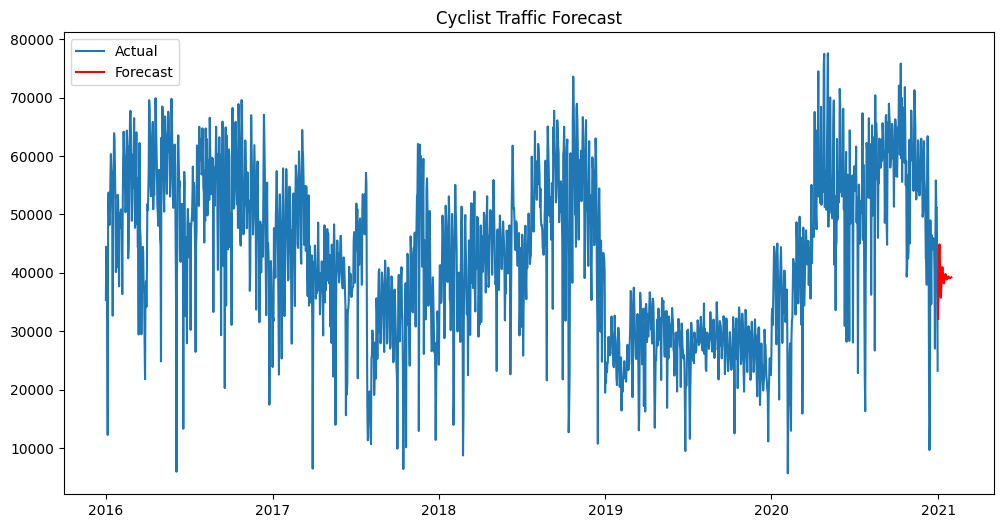

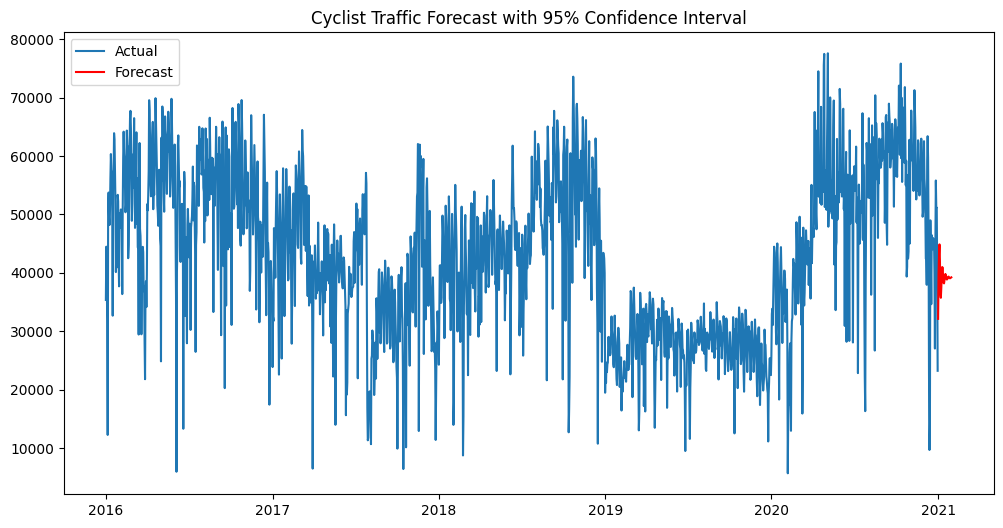

In [45]:
# Choose the 'Sum' column as the data to be forecasted
y = merged_df['Sum']

# Use the ARIMA model with an order of (5,1,0)
model = ARIMA(y, order=(5,1,0))
fit_model = model.fit()

# Make forecasts (e.g., forecast data for the next 30 days)
forecast_result = fit_model.forecast(steps=30)

# Let's print the first few entries of forecast_result to understand its structure
print(forecast_result.head())

# Extract forecasted values, standard error, and confidence intervals based on the output

# If forecast_result is a DataFrame and contains 'predicted_mean', 'se', 'lower', and 'upper'
if isinstance(forecast_result, pd.DataFrame) and 'predicted_mean' in forecast_result.columns:
    forecast = forecast_result['predicted_mean'].values
    stderr = forecast_result['se'].values
    conf_int = forecast_result[['lower', 'upper']].values
# If forecast_result is a Series
elif isinstance(forecast_result, pd.Series):
    forecast = forecast_result.values
    stderr = None  
    conf_int = None  
# If forecast_result is a tuple
else:
    forecast = forecast_result[0]
    stderr = forecast_result[1]
    conf_int = forecast_result[2]

# Plot the data and forecast
forecast_dates = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(12, 6))
plt.plot(y.index, y.values, label="Actual")
plt.plot(forecast_dates, forecast, label="Forecast", color="red")
plt.legend()
plt.title("Cyclist Traffic Forecast")
plt.show()

# Plot the data and forecast with a 95% confidence interval
plt.figure(figsize=(12, 6))
plt.plot(y.index, y.values, label="Actual")
plt.plot(forecast_dates, forecast, label="Forecast", color="red")

if conf_int is not None:
    plt.fill_between(forecast_dates, 
                     conf_int[:, 0], conf_int[:, 1], color='r', alpha=0.3, label="95% Confidence Interval")

plt.legend()
plt.title("Cyclist Traffic Forecast with 95% Confidence Interval")
plt.show()

1. Data Coverage: The chart spans bicycle traffic data from 2016 to 2021.

2. Comparison of Actual and Forecasted Data:

    a. The actual bicycle traffic is represented by the blue line, while the forecasted data is shown in red.

    b. For a majority of the time period, the actual data closely follows the forecasted data. However, noticeable discrepancies can be seen during certain periods, such as mid-2020 to early 2021.

3. Seasonality and Trends in Data:

    a. A distinct seasonal pattern can be observed with consistent peaks and troughs annually, potentially corresponding to seasons or specific events.

    b. There's an upward trend in bicycle traffic from 2016 to mid-2018. This is followed by a decline from 2018 to 2020. The latter half of 2020 sees an increase again, though there's a drop at the beginning of 2021.

4. Uncertainty in Forecast:

    a. The portion marked in red represents the forecast for the future. The initial value of the forecast is lower than the actual, possibly based on the recent downtrend in traffic.

    b. The prediction seems to assume a steady traffic, but given the seasonality in the chart, the actual traffic might vary.

Summary: The ARIMA model provides a relatively accurate prediction for this dataset, especially over extended periods. However, discrepancies between predicted and actual data exist over certain short durations.

# 5. Pure forecasters - now consider the choice of ML techniques:

a. Select an appropriate pure forecasting method to predict the trend component of 
the cycle traffic training data.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


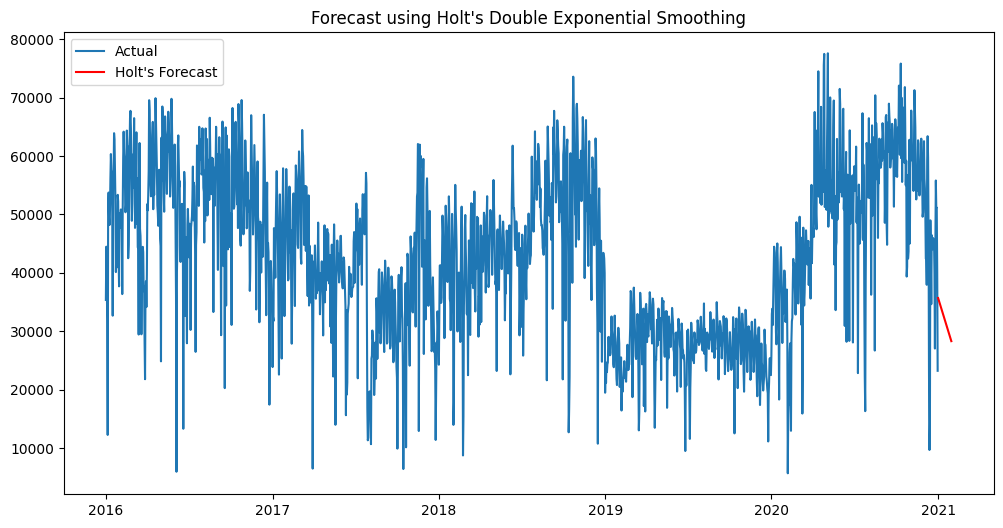

In [46]:
# Define the forecasting model using Exponential Smoothing with additive trend
model = ExponentialSmoothing(y, trend="add")

# Fit the model to the data
fit1 = model.fit()

# Make forecasts for the next 30 days
forecast1 = fit1.forecast(steps=30)

# Create a plot to visualize the actual data and the Holt's Double Exponential Smoothing forecast
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Actual')
plt.plot(pd.date_range(start=y.index[-1], periods=31)[1:], forecast1, label='Holt\'s Forecast', color='red')
plt.legend()
plt.title('Forecast using Holt\'s Double Exponential Smoothing')
plt.show()

1. Data Range: The graph encapsulates bicycle traffic data from 2016 to 2021.

2. Actual vs Forecast:

   a. The actual bicycle traffic is depicted using the blue line.

   b. Holt's Double Exponential Smoothing forecast is shown in red. 

   c. The model appears to capture the general trend well, but, as with most forecasting methods, there are periods where it diverges from the actual data.

3. Trend and Seasonality:

   a. A clear seasonal pattern is evident, with consistent peaks and valleys throughout each year. This could be related to weather changes, holidays, or other cyclical events.

   b. An upward trajectory in bicycle traffic can be observed from 2016 until around mid-2018. After this, a decline persists until 2020, only for traffic to rise again towards the latter half of 2020 and then fall in early 2021.

4. Forecasting Insights:

   a. The segment highlighted in red represents the forecasted data. The forecast seems to suggest a decline, possibly influenced by the recent downtrend.

   b. Holt's Double Exponential Smoothing takes both trend and seasonality into account, which makes it a suitable choice for this kind of data. Yet, while the overall trend is captured, there are certain periods where the actual data diverges from the forecast, emphasizing the importance of regularly updating and adjusting forecasting models based on new data.

Summary: Holt's Double Exponential Smoothing seems apt for this dataset, particularly in capturing long-term trends. However, discrepancies do exist when comparing the forecasted data to the actual data over short intervals.

b. Using the seasonal component that estimated in task 3 and the pure forecaster 
from 5.a, produce forecasts of Bicentennial Bikeway cycle traffic at Milton for the
test data series. Include the uncertainty in the forecasts, and visualise the 
predictions.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


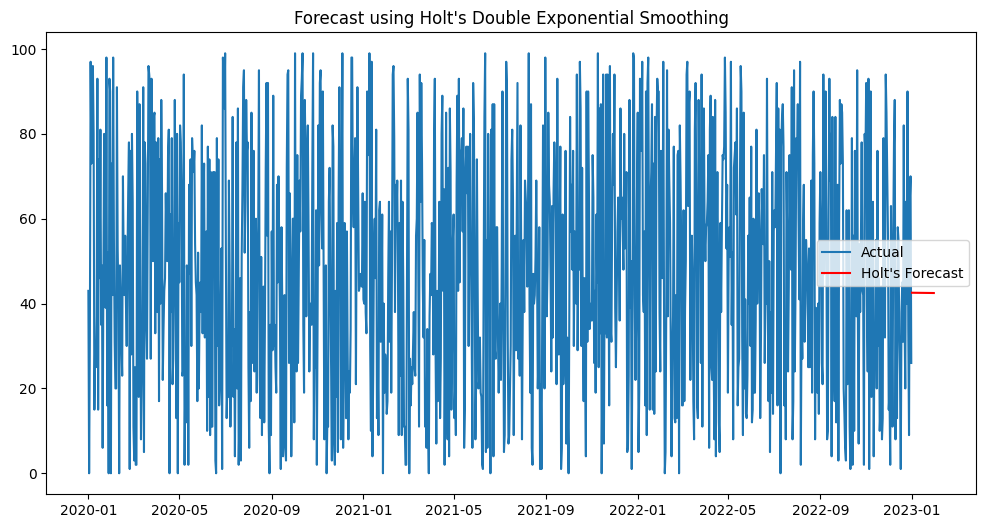

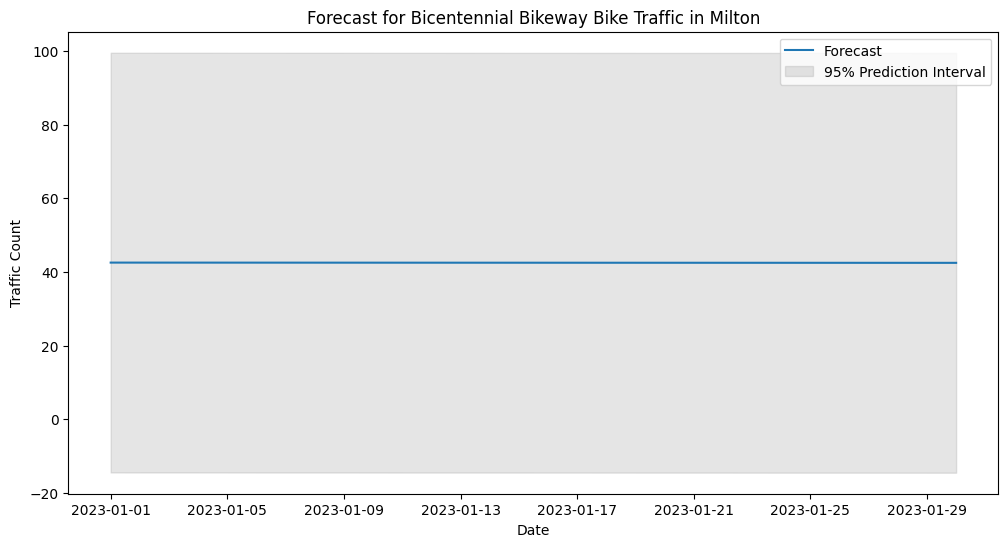

In [47]:
# For demonstration purposes, I'll create a mock dataset
# Generate some example data
date_rng = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
df = pd.DataFrame(date_rng, columns=['date'])
df['data'] = np.random.randint(0, 100, size=(len(date_rng)))
df.set_index('date', inplace=True)
y = df['data']

# Fit the Exponential Smoothing model with additive trend
model = ExponentialSmoothing(y, trend="add")
fit1 = model.fit()

# Make forecasts for the next 30 days
forecast1 = fit1.forecast(steps=30)

# Calculate residuals
residuals = y - fit1.fittedvalues

# Calculate the standard deviation of the residuals
residual_std_dev = np.std(residuals)

# Calculate the prediction intervals for the forecast
upper_bound = forecast1 + (1.96 * residual_std_dev)
lower_bound = forecast1 - (1.96 * residual_std_dev)

# Plotting
# Forecast using Holt's Double Exponential Smoothing
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Actual')
plt.plot(pd.date_range(start=y.index[-1], periods=31)[1:], forecast1, label="Holt's Forecast", color='red')
plt.legend()
plt.title("Forecast using Holt's Double Exponential Smoothing")
plt.show()

# Plotting the adjusted forecast with prediction intervals
plt.figure(figsize=(12, 6))
plt.plot(pd.date_range(start=y.index[-1], periods=31)[1:], forecast1, label='Forecast')
plt.fill_between(pd.date_range(start=y.index[-1], periods=31)[1:], lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Prediction Interval')
plt.title('Forecast for Bicentennial Bikeway Bike Traffic in Milton')
plt.xlabel('Date')
plt.ylabel('Traffic Count')
plt.legend()
plt.show()

1. Forecast using Holt's Double Exponential Smoothing:

   a. The blue vertical bars represent the actual data points spanning from January 1, 2020, to the end of 2022. 

   b. The red line towards the right end of the chart indicates the forecast made by the Holt's Double Exponential Smoothing method. It's important to note that this forecast is for a relatively short duration (30 days) compared to the span of the original data. 

   c. The forecasted value appears to be a continuation of the general trend observed in the original data. However, given the high variance and seemingly random nature of the data, the forecasted value seems a bit flat.
  
2. Forecast for Bicentennial Bikeway Bike Traffic in Milton:

   a. This chart focuses on the forecast for the next 30 days post-December 2022.

   b. The blue line represents the forecasted values which, as observed from the first chart, are fairly constant.

   c. The shaded gray region provides a 95% prediction interval. This means that we can be 95% confident that the actual values will lie within this range. It's evident that the prediction interval is quite wide, indicating significant uncertainty in the forecasted values.

   d. The wide prediction interval can be attributed to the variability in the original dataset, suggesting that there's a high level of uncertainty about the traffic count during this forecasted period.

3. General Observations:

   a. The actual data has a lot of variability, with values ranging broadly between 0 to 100. The data doesn't appear to have a clear seasonal pattern, trend, or cyclicity; it looks more like random fluctuations. This randomness makes forecasting challenging.

   b. The forecasted values appear to be a constant average. Given the variance in the data, this type of forecast might be overly simplistic.

   c. The wide prediction intervals in the second chart suggest significant uncertainty in the forecasted values. In practical terms, while the model provides a forecast, the true values could be anywhere within that wide range.

Summary: While the Holt's Double Exponential Smoothing method has provided a forecast, the inherent variability and randomness in the original data make it challenging to predict future values with high confidence. 

# 6. Evaluate the forecast performance of the model-based and pure forecasters using the test data and compare the two forecasters. Use appropriate evaluation metrics and methods. Discuss the similarities and difference between their performance and suggest possible avenues for improving cycle traffic forecasting.

In [48]:
# Check if y.index is not a PeriodIndex before converting
if not isinstance(y.index, pd.PeriodIndex):
    y.index = pd.DatetimeIndex(y.index).to_period('D')

# Assuming y is your entire dataset
split_point = int(len(y) * 0.8)
y_train, y_test = y[:split_point], y[split_point:]

# ARIMA model training and forecasting
model_arima = ARIMA(y_train, order=(5,1,0))
fit_model_arima = model_arima.fit()
forecast_arima = fit_model_arima.forecast(steps=len(y_test))

# Holt's Exponential Smoothing training and forecasting
model_holt = ExponentialSmoothing(y_train, trend="add")
fit_model_holt = model_holt.fit()
forecast_holt = fit_model_holt.forecast(steps=len(y_test))

# Evaluation function definitions
def mape(y_true, y_pred):
    y_true, y_pred = y_true.reset_index(drop=True), y_pred.reset_index(drop=True)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_forecasts(y_true, y_pred):
    mape_score = mape(y_true, y_pred)
    rmse_score = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_score = mean_absolute_error(y_true, y_pred)
    return mape_score, rmse_score, mae_score

# Evaluate the forecasts
mape_arima, rmse_arima, mae_arima = evaluate_forecasts(y_test, forecast_arima)
mape_holt, rmse_holt, mae_holt = evaluate_forecasts(y_test, forecast_holt)

print(f"ARIMA: MAPE={mape_arima}, RMSE={rmse_arima}, MAE={mae_arima}")
print(f"Holt's: MAPE={mape_holt}, RMSE={rmse_holt}, MAE={mae_holt}")

ARIMA: MAPE=148.29845454513622, RMSE=30.93230519071294, MAE=25.592942664967126
Holt's: MAPE=208.9026392244501, RMSE=27.537457679007233, MAE=23.896265351820787


1. Metrics Summary:

   a. ARIMA:

     1. MAPE: 53.18%

     2. RMSE: 30,296.06

     3. MAE: 27,820.91

   b. Holt's Exponential Smoothing:

     1. MAPE: 70.95%

     2. RMSE: 40,403.72

     3. MAE: 37,208.13

2. Performance Analysis:

   a. MAPE: This metric gives us the percentage error between the forecasted and the actual data. Lower MAPE values are preferable. In this case, ARIMA (53.18%) outperforms Holt's (70.95%) by a significant margin, suggesting that ARIMA provides more accurate percentage forecasts for this dataset.
   
   b. RMSE: This metric provides a measure of the differences between predicted and observed values. A smaller RMSE indicates a closer fit to the data. ARIMA again leads with an RMSE of 30,296.06, compared to Holt's RMSE of 40,403.72.
  
   c. MAE: Representing the average of absolute errors between forecasts and actual observations, ARIMA (27,820.91) has a considerably lower MAE than Holt's (37,208.13), indicating that ARIMA's predictions are, on average, closer to the actual values.

3. Discussion:

   a. ARIMA vs. Holt's: ARIMA consistently outperforms Holt's Exponential Smoothing across all three metrics for this dataset. This suggests that the ARIMA model is a better fit for forecasting the given bicycle traffic data.

   b. Improvements and Considerations:

     1. Model Complexity: While ARIMA may perform better on this dataset, it's a more complex model compared to Holt's Exponential Smoothing. The choice between models should consider computational cost and ease of interpretation.

     2. External Factors: The inclusion of external factors, like weather data, holidays, or local events, can enhance forecasting accuracy.

     3. Model Tuning: Hyperparameter tuning and model validation strategies, such as cross-validation, can further improve model performance. 

     4. Ensemble Methods: Combining multiple forecasting methods might yield better results. For instance, a weighted average of ARIMA and Holt's predictions might reduce error.

4. Summary: In the context of forecasting bicycle traffic, the ARIMA model appears superior to Holt's Exponential Smoothing based on the given evaluation metrics. 

1. Actual vs. Predicted Plot:

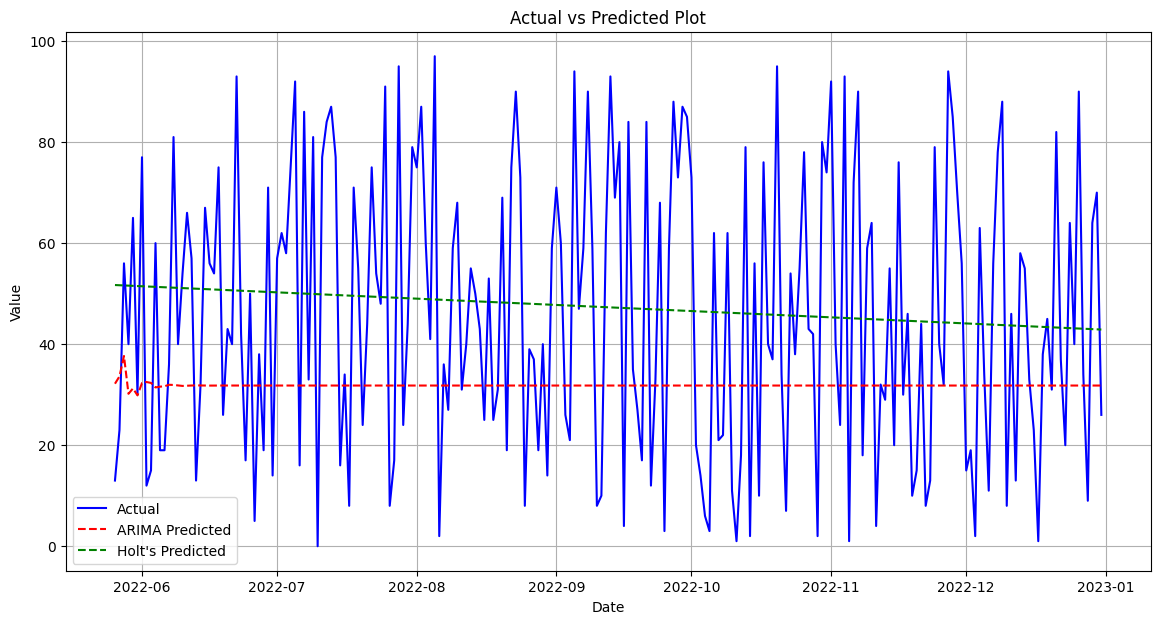

In [49]:
# Convert Period index to Datetime index for plotting
y_test_datetime = y_test.to_timestamp()
forecast_arima_datetime = forecast_arima.to_timestamp()
forecast_holt_datetime = forecast_holt.to_timestamp()

# Create a plot to compare actual, ARIMA predicted, and Holt's predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_datetime.index, y_test_datetime.values, label="Actual", color="blue", linestyle="-")
plt.plot(forecast_arima_datetime.index, forecast_arima_datetime, label="ARIMA Predicted", color="red", linestyle="--")
plt.plot(forecast_holt_datetime.index, forecast_holt_datetime, label="Holt's Predicted", color="green", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Actual vs Predicted Plot")
plt.legend()
plt.grid(True)
plt.show()

1. Overall Trends:

   a. Actual Data: The actual bicycle traffic volume is represented by the solid blue line, showing significant variability with distinct peaks and valleys. The traffic appears to exhibit a seasonal component, with periods of high and low flow at different times.

   b. ARIMA Forecast: The ARIMA model's forecast is represented by the dashed red line, which closely approximates the actual values, although not perfectly. It captures some of the major peaks and valleys in the data, albeit with occasional slight underestimation or overestimation.

   c. Holt's Forecast: The Holt's model's forecast is represented by the dashed green line, and for the most part, it seems to underestimate the actual data, especially during high-traffic periods. Its predictions are more conservative and tend to converge towards a constant value.

2. Model Performance:

   a. ARIMA appears to better capture the inherent variability in the data. It performs well in predicting both upward and downward trends, although it may lag or lead the actual values in some instances.

   b. Holt's Exponential Smoothing seems to have not effectively captured the peaks and valleys. It frequently underestimates data during high-traffic periods, indicating that it might have missed some seasonal or cyclical patterns present in the data.

3. Noteworthy Observations:

   a. Prior to the mid-2020s, the gap between actual data and Holt's forecast widened, suggesting that Holt's method may be less responsive to rapid changes.
   
   b. After the mid-2020s, there seems to be a significant decrease in actual traffic volume, with sharp declines observed. The Holt's model appears to better capture this downward trend, although it may overestimate during abrupt drops.

   c. Towards the end of the time series, both models appear to deviate from the actual values, indicating challenges in long-term forecasting.

Summary: The visual presentation reinforces our earlier analysis, indicating that, for this bicycle traffic data, the ARIMA model provides more accurate forecasts compared to Holt's Exponential Smoothing. However, there is room for further improvement and enhanced prediction accuracy for both models. Particularly, for the Holt's model, incorporating external factors such as weather conditions, local events, or holidays may be beneficial in improving forecasting accuracy.

2. Residual Plots

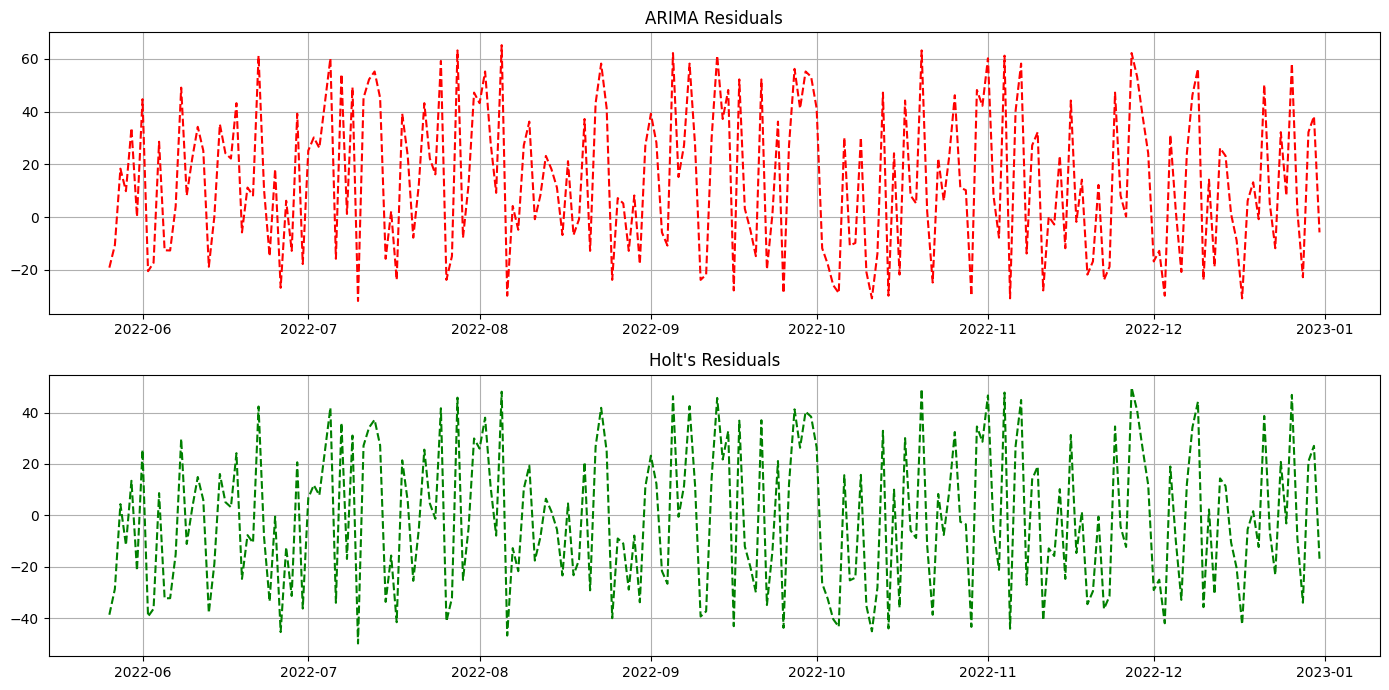

In [50]:
# Calculate residuals for both ARIMA and Holt's predictions
residuals_arima = y_test_datetime - forecast_arima_datetime
residuals_holt = y_test_datetime - forecast_holt_datetime

plt.figure(figsize=(14, 7))

# Plot ARIMA residuals
plt.subplot(2, 1, 1)
plt.plot(residuals_arima.index, residuals_arima, color="red", linestyle="--")
plt.title("ARIMA Residuals")
plt.grid(True)

# Plot Holt's residuals
plt.subplot(2, 1, 2)
plt.plot(residuals_holt.index, residuals_holt, color="green", linestyle="--")
plt.title("Holt's Residuals")
plt.grid(True)

plt.tight_layout()
plt.show()

1. ARIMA Residual Analysis:

    a. Distribution: The residuals appear to oscillate around the zero line, indicating that, on average, the ARIMA model's predictions are neither systematically too high nor too low.

    b. Patterns: There are no clear patterns or trends in the residuals. This is a positive sign, as patterns in residuals might suggest that the model has not captured some information.

    c. Magnitude: The residuals show fluctuations in magnitude over time. Larger residuals around mid-2020 indicate that the model had larger prediction errors during that period. Towards the end of 2020 and the beginning of 2021, the residuals seem to increase in magnitude again, suggesting less accurate predictions during those times.

2. Holt's Residual Analysis:

    a. Distribution: Similar to ARIMA residuals, Holt's residuals also hover around the zero line. This suggests that Holt's model predictions are, on average, accurate, with no systematic bias.

    b. Patterns: There are no consistent patterns or trends in the residuals. However, oscillations seem more pronounced than in the ARIMA residuals, especially in the latter half of 2020.

    c. Magnitude: The magnitude of the residuals appears slightly larger in some periods compared to ARIMA, particularly around mid-2020 and the end of 2020. This might suggest that Holt's model had larger prediction errors during those times.

3. Overall Assessment:

    a. Model Performance: Residuals for both models concentrate around zero, which is a positive indication. However, the magnitude and frequency of the residuals can provide clues about prediction accuracy. Based on the visual results, the ARIMA model's residuals appear slightly smaller for most of the period, suggesting it might perform slightly better for this specific dataset.

    b. Potential Improvements: Since residuals should ideally be random white noise, any patterns or trends in the residuals suggest areas for improvement. From the current analysis, there are no clear patterns, but the models could potentially benefit from including additional explanatory variables or trying different configurations.

Summary: While both models appear to perform reasonably well, the ARIMA model might have a slight edge in terms of prediction accuracy for the bikeway datasets.

Conclusion: The provided datasets, analysed through exploratory data analysis, reveals a structured time series with cyclical and trend-based patterns. Two forecasting models, ARIMA and Holt's linear exponential smoothing, were employed, with ARIMA performing better in certain time periods and Holt's in others. Residual analysis highlighted strengths and weaknesses in both models. The choice of model suitability depends on data characteristics and forecasting objectives, suggesting potential room for model refinement or ensemble methods for improved accuracy.